<a href="https://colab.research.google.com/github/marcochisci/Anomaly_detection/blob/main/6hours_AnomalyDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Airquino table Data
Average data values (every 6 hours) of every month since July to predict the first 18 days of November 2021

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC
Dates,,,,,,,,,,
2021-06-29 06:00:00,457.703704,1.296296,410.481481,43.327778,29.644444,6.037037,404.148148,244.000000,216.629630,375.481481
2021-06-29 12:00:00,523.896175,1.218579,408.027322,46.536011,32.412022,6.737705,384.519126,253.109290,226.464481,404.349727
2021-06-29 18:00:00,452.995327,1.238318,407.990654,42.546636,28.035047,6.032710,490.635514,249.331776,226.074766,376.369159
2021-06-30 00:00:00,391.943723,1.943723,410.969697,38.649913,23.567965,8.251082,636.030303,259.796537,228.363636,349.277056
2021-06-30 06:00:00,414.850877,1.890351,406.438596,41.504825,26.664474,10.688596,487.500000,278.307018,219.114035,364.780702
...,...,...,...,...,...,...,...,...,...,...
2021-11-17 18:00:00,97.312236,6.358650,421.202532,24.456624,13.205485,7.438819,743.995781,30.139241,201.704641,274.848101
2021-11-18 00:00:00,221.296943,10.611354,448.135371,22.097948,10.446288,13.362445,872.641921,138.873362,208.816594,303.371179
2021-11-18 06:00:00,258.812227,6.052402,440.331878,27.068122,15.564629,8.593886,716.078603,87.048035,212.947598,310.414847


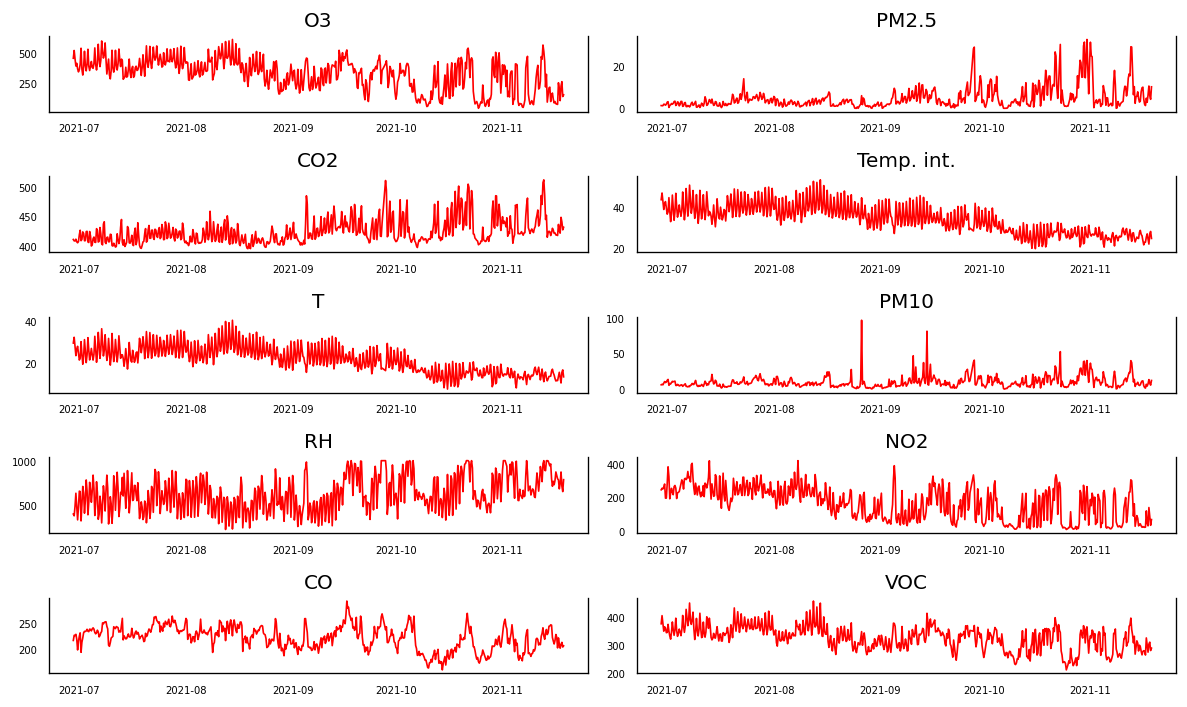

In [1]:
import pandas as pd
import psycopg2
import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import numpy as np
%matplotlib inline


conn = psycopg2.connect(host='playground.magentalab.it', port='45432', database='airqino', user='datareader', password='homntLZnlhQd9prtVA9SFezQek')

query=""" select time_bucket('6 hour', c."Dates" ) as "bucket", avg(c."O3") as "O3" ,  avg(c."PM2.5") as "PM2.5", avg(c."CO2") as "CO2",
 avg(c."Temp. int.") as "Temp. int.",  avg(c."T") as "T",  avg(c."PM10") as "PM10", avg(c."RH") as "RH", avg(c."NO2") as 
 "NO2", avg(c."CO") as "CO", avg(c."VOC") as "VOC"
from (select * from crosstab(
  'select sd.data_acquired as timestamp, s.sensor_type ,  sd.float_value as value 
from station_data sd join sensor s on s.id = sd.sensor_id
where sd.data_acquired >= to_timestamp(''2021-06-01 00:00:00'', ''YYYY-mm-dd HH24:MI:SS'')
 and sd.data_acquired <= to_timestamp(''2021-11-19 00:00:00'', ''YYYY-mm-dd HH24:MI:SS'')
and sd.station_id = 23284701 order by sd.data_acquired asc, 1'
 , $$VALUES ('O3'::varchar), ('PM2.5'::varchar), ('CO2'::varchar), ('Temp. int.'::varchar), ('T'::varchar)
 , ('PM10'::varchar), ('RH'::varchar), ('NO2'::varchar), ('CO'::varchar), ('VOC'::varchar)$$
) AS value ("Dates" timestamp, "O3" float, "PM2.5" float, "CO2" float, "Temp. int." float, "T" float, "PM10" float,
"RH" float, "NO2" float, "CO" float, "VOC" float))  c 
group by bucket
order by bucket asc;
 """
df = pd.read_sql(query, conn)
df= df.rename(columns={'bucket': 'Dates'})
df=df.set_index('Dates')
#fix temp int
df['Temp. int.'] = df['Temp. int.'].div(100)
df['T'] = df['T'].div(10)
df=df.dropna()


display(df)

# Plot
fig, axes = plt.subplots(nrows=5, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

# Testing stationarity 

In [ ]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(ts_data, column='', signif=0.05, series=False):
    if series:
        adf_test = adfuller(ts_data, autolag='AIC')
    else:
        adf_test = adfuller(ts_data[column], autolag='AIC')
    p_value = adf_test[1]                   
    if p_value <= signif:
        test_result = "Stationary"
    else:
        test_result = "Non-Stationary"
    return test_result

adf_test_results = {
    col: test_stationarity(df, col)
    for col in df.columns
}
adf_test_results     

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


{'CO': 'Stationary',
 'CO2': 'Stationary',
 'NO2': 'Non-Stationary',
 'O3': 'Stationary',
 'PM10': 'Stationary',
 'PM2.5': 'Stationary',
 'RH': 'Stationary',
 'T': 'Non-Stationary',
 'Temp. int.': 'Non-Stationary',
 'VOC': 'Stationary'}

Converting to stationary with differencing

In [2]:
#before the first differencing
df_copy= df.copy()
df_d=df.copy()

In [ ]:
def differencing(data, column, order):
    differenced_data = data[column].diff(order)
    differenced_data.fillna(differenced_data.mean(), inplace=True)
    return differenced_data
for col in df.columns:
    df[col] = differencing(df, col, 1)

Test for stationarity now

# VAR model

Finding the best lag for VAR model (if the max_lag value is too high the model may not work)

In [ ]:
from statsmodels.tsa.api import VAR
max_lag = 15
var_model = VAR(df)
# select the best lag order
lag_results = var_model.select_order(max_lag)
selected_lag = lag_results.aic
print(selected_lag)

4


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Calculating the errors

In [ ]:
import numpy as np
import scipy as sp

#mahalanobis distance
def mahalanobis(x=None, data=None, cov=None):
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = sp.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()
var = VAR(df)
var_fitresults = var.fit(selected_lag)
var_fit_df=pd.DataFrame(var_fitresults.fittedvalues, index=df_copy.index[selected_lag:], columns=df.columns)
errors = mahalanobis(x=var_fit_df, data= df)
errors_df=pd.DataFrame(errors, index=df_copy.index[selected_lag:], columns={"errors"})

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


# Testing the mahalanobis errors' distribution and finding the thresholds

In [ ]:
pip install fitter


     |████████████████████████████████| 47 kB 4.0 MB/s 
  Created wheel for fitter: filename=fitter-1.4.0-py3-none-any.whl size=25025 sha256=8db268ac402c4b3763ce18b4d2cfaac744624f1e5f0ea8292152ea5fb01945d0
  Stored in directory: /root/.cache/pip/wheels/e1/98/16/e5263962f94fbfaad79902aa94652516caccc1f1d51509e853
  Created wheel for easydev: filename=easydev-0.12.0-py3-none-any.whl size=64232 sha256=f71ca47c27ac01776e1bfb3bb9768ea8340180c23d367b7afbbf678e4c70b99f
  Stored in directory: /root/.cache/pip/wheels/82/ab/83/fdfc4017ea44a585b6754752cc5f63f2d0d63fcc1317e7174b
Successfully built fitter easydev


Make a histogram

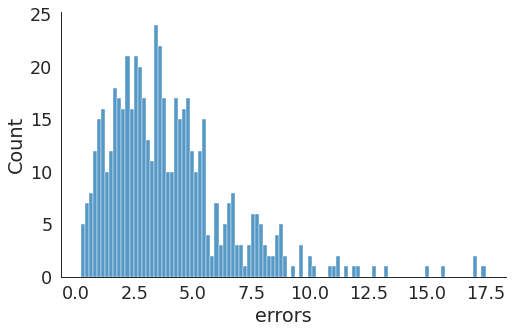

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions
import scipy.stats as stats
#remove outliers
z_scores = stats.zscore(errors_df)

abs_z_scores = np.abs(z_scores)
filtered_errors = (abs_z_scores < 3).all(axis=1)
new_errors_df = errors_df[filtered_errors]

sns.set_style('white')
sns.set_context("paper", font_scale = 2)
sns.displot(data=new_errors_df, x="errors", kind="hist", bins = 100, aspect = 1.5)

Find the best distribution (the output ranks the best distributions in ascending order)

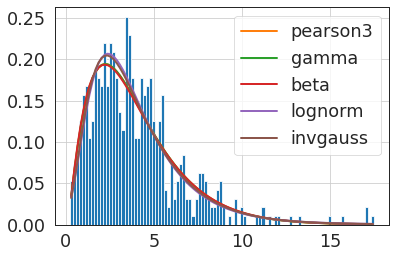

In [ ]:
er = new_errors_df["errors"].values
er_min=min(er)
er_max=max(er)
f = Fitter(er,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang'])
f.fit()
f.summary()
pearson_param=f.fitted_param["pearson3"]

threshold low: 9.426251878795695
threshold med: 10.032098904795314
threshold high: 10.88028474119478


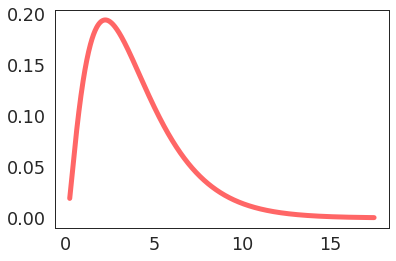

In [ ]:
from scipy.stats import pearson3
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)

skew = pearson_param[0]
loc, scale = pearson_param[1], pearson_param[2]

#graph to test if the parameters are correct
x = np.linspace(er_min,er_max, 1000)
ax.plot(x, pearson3.pdf(x, skew, loc, scale),
       'r-', lw=5, alpha=0.6, label='invgauss pdf')

# using the cdf
found=0
for i in x:
  if ((pearson3.cdf(i,skew, loc, scale)>0.96) & (found<1)):
    threshold_l=i
    found=1
  if ((pearson3.cdf(i,skew, loc, scale)>0.97) & (found<2)):
    threshold_m=i
    found=2
  if ((pearson3.cdf(i,skew, loc, scale)>0.98) & (found<3)):
    threshold_h=i
    found=3
print('threshold low: '+str(threshold_l))
print('threshold med: '+str(threshold_m))
print('threshold high: '+str(threshold_h))

# Finding anomalies with mahalanobis distance

In [ ]:
#0 means that is it not an anomaly
def find_anomalies(errors, threshold_low, threshold_med, threshold_high):
  predictions=pd.DataFrame(np.zeros((len(errors), 1)))
  for i in range(len(errors)):
    if((errors.iloc[i].values >= threshold_low) &(errors.iloc[i].values < threshold_med)):
      predictions.iloc[i]=1
    if((errors.iloc[i].values >= threshold_med) &(errors.iloc[i].values < threshold_high)):
      predictions.iloc[i]=2
    if(errors.iloc[i].values >= threshold_high):
      predictions.iloc[i]=3
  return predictions

predictions = find_anomalies(abs(errors_df),threshold_l, threshold_m, threshold_h)

Select how many values do you want to predict: there are 4 values each day.

If you want to find the anomalies of the first 18 days of November hom_many should be set at 72

In [ ]:
data = df_copy.iloc[selected_lag-1: -1, :]
data['Predictions'] = predictions.values
how_many=72
data=data.iloc[-how_many:,:]
data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions
Dates,,,,,,,,,,,
2021-10-31 18:00:00,277.360169,21.207627,438.766949,28.260975,15.982203,25.902542,691.220339,119.521186,213.762712,316.572034,0.0
2021-11-01 00:00:00,402.337662,31.506494,449.190476,26.526017,14.200000,36.363636,895.038961,186.818182,228.268398,333.246753,0.0
2021-11-01 06:00:00,320.824034,24.969957,437.690987,25.941631,13.718455,28.557940,999.000000,149.738197,243.128755,325.540773,0.0
2021-11-01 12:00:00,399.983051,24.627119,441.593220,26.772585,14.772458,27.639831,999.000000,224.165254,252.690678,353.207627,0.0
2021-11-01 18:00:00,386.911017,12.754237,438.500000,26.915551,14.761864,16.220339,999.000000,201.322034,257.521186,348.605932,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2021-11-17 12:00:00,192.921053,2.877193,424.942982,26.991886,15.575000,4.302632,684.710526,46.061404,210.179825,300.719298,0.0
2021-11-17 18:00:00,97.312236,6.358650,421.202532,24.456624,13.205485,7.438819,743.995781,30.139241,201.704641,274.848101,0.0
2021-11-18 00:00:00,221.296943,10.611354,448.135371,22.097948,10.446288,13.362445,872.641921,138.873362,208.816594,303.371179,0.0


In [ ]:
data['Predictions'].value_counts()

0.0    72
Name: Predictions, dtype: int64

# Showing the anomalies found with Mahalanobis distance with tables

The anomaly is shown with the 3 previous values, all the following anomalous values and the following 2 non-anomalous values

> The first anomaly is always the 4-th row



Diplay all the anomalies

In [ ]:
index_no = data.columns.get_loc('Predictions')
i=0
while(i<len(data)):
  if(data.iloc[[i],[index_no]].values !=0):
    j=i+1
    if(j>=len(data)):
      break
    else:
       while(data.iloc[[j],[index_no]].values !=0):
          j=j+1
          if(j>=len(data)):
            j=j-1
            break
    for s in range(i,j):
      d=0
      for col in df.columns:
        dis=float(data.iloc[[s],[d]].values-data.iloc[[s-1],[d]].values)
        print(col+':'+str(dis))
        d=d+1
      print ('*' * 20)
    if(i-3<0):
      tmp=data.iloc[i: j + 2]
      display(tmp)
    if(j+2>len(data)):
      tmp=data.iloc[i -3: j]
      display(tmp)
    else:
      tmp=data.iloc[i - 3 : j + 2]
      display(tmp)
    i=j
  else:
    i=i+1     

O3:-106.31528443826193
PM2.5:-17.23063476955742
CO2:-0.3965021781308451
Temp. int.:-0.34652999963392617
T:-0.3010703042061724
PM10:-14.802654940147162
RH:-47.302375809935256
NO2:-61.62053391660871
CO:-13.747400885895246
VOC:-25.567686788446792
********************


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions
Dates,,,,,,,,,,,
2021-10-31 12:00:00,219.241015,14.040169,432.253700,29.727146,17.740169,17.706131,616.334038,76.847780,208.723044,293.972516,0.0
2021-11-01 00:00:00,361.405172,28.224138,443.415948,26.232565,13.958190,32.443966,947.243534,168.198276,235.730603,329.377155,0.0
2021-11-01 12:00:00,393.447034,18.690678,440.046610,26.844068,14.767161,21.930085,999.000000,212.743644,255.105932,350.906780,0.0
2021-11-02 00:00:00,287.131749,1.460043,439.650108,26.497538,14.466091,7.127430,951.697624,151.123110,241.358531,325.339093,3.0
2021-11-02 12:00:00,153.357294,3.494715,419.613108,28.589133,16.419450,15.583510,734.484144,52.505285,216.021142,292.942918,0.0
2021-11-03 00:00:00,222.409910,2.680180,435.222973,25.655766,13.218243,12.031532,904.430180,131.684685,215.713964,305.635135,0.0


Witch anamaly do you want to display? (enter a number)

In [ ]:
input_a =int(input("Type the number of the anomaly you want to display:"))
index_no = data.columns.get_loc('Predictions')
cnt=0
i=0
while(i<len(data)):
  if(data.iloc[[i],[index_no]].values !=0):
    cnt=cnt+1
    j=i+1
    while(data.iloc[[j],[index_no]].values !=0):
      j=j+1
    if(input_a == cnt):
      for s in range(i,j):
        d=0
        for col in df.columns:
          dis=float(data.iloc[[s],[d]].values-data.iloc[[s-1],[d]].values)
          print(col+':'+str(dis))
          d=d+1
        print ('*' * 20)
      if(i-3<0):
        tmp=data.iloc[i: j + 2]
        display(tmp)
      if(j+2>len(data)):
        tmp=data.iloc[i-2: j]
        display(tmp)
      else:
        tmp=data.iloc[i - 3 : j + 2]
        display(tmp)
      i=len(data+1)
    i=j
  else:
    i=i+1   


Type the number of the anomaly you want to display:2
O3:-168.77959359706438
PM2.5:-1.9186853002700985
CO2:-7.207630014704989
Temp. int.:-3.344408054960283
T:-2.7410581729533305
PM10:-5.266859240434155
RH:-111.57521402612781
NO2:-84.42218488787309
CO:-26.234896949480458
VOC:-39.17894984350846
********************
O3:39.38786122415425
PM2.5:-0.47291075759444245
CO2:3.0959222263329025
Temp. int.:0.7415585563365781
T:0.45924487195297203
PM10:-0.41221687836560195
RH:-77.05944012825262
NO2:21.019648949726644
CO:-11.637707074444052
VOC:12.116927693509297
********************
O3:43.001223576517674
PM2.5:0.8413578284166519
CO2:10.878091032208658
Temp. int.:-0.004482046752627866
T:-0.15430477536359888
PM10:2.8133639521874816
RH:99.3425189895778
NO2:26.506259200376846
CO:12.551413766707896
VOC:14.768105752811607
********************


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions
Dates,,,,,,,,,,,
2021-08-26,341.027344,3.074219,416.156250,37.761367,25.437891,35.726206,527.014323,147.105469,221.369792,321.555990,0
2021-08-27,352.658617,2.926454,411.792536,36.600834,24.200659,7.055982,675.373216,150.361142,236.435785,317.276619,0
2021-08-28,183.879023,1.007769,404.584906,33.256426,21.459600,1.789123,563.798002,65.938957,210.200888,278.097669,1
2021-08-29,223.266885,0.534858,407.680828,33.997985,21.918845,1.376906,486.738562,86.958606,198.563181,290.214597,1
2021-08-30,266.268108,1.376216,418.558919,33.993503,21.764541,4.190270,586.081081,113.464865,211.114595,304.982703,1


# Showing the anomalies found with Mahalanobis distance with graphs

get all the anomalies

In [ ]:
anomalies_l= data[(data['Predictions'] == 1)]
anomalies_m= data[(data['Predictions'] == 2)]
anomalies_h= data[(data['Predictions'] == 3)]

Get the day before to compare

In [ ]:
day_before= df_copy.iloc[-(how_many*2):-how_many,:]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Indexing with a float is deprecated, and will raise an IndexError in pandas 2.0. You can manually convert to an integer key instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: Indexing with a float is deprecated, and will raise an IndexError in pandas 2.0. You can manually convert to an integer key instead.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning: Indexing with a float is deprecated, and will raise an IndexError in pandas 2.0. You can manually convert to an integer key instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: FutureWarning: Indexing with a float is deprecated, and will raise an IndexError in pandas 2.0. You can manually convert to an integer key instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: F

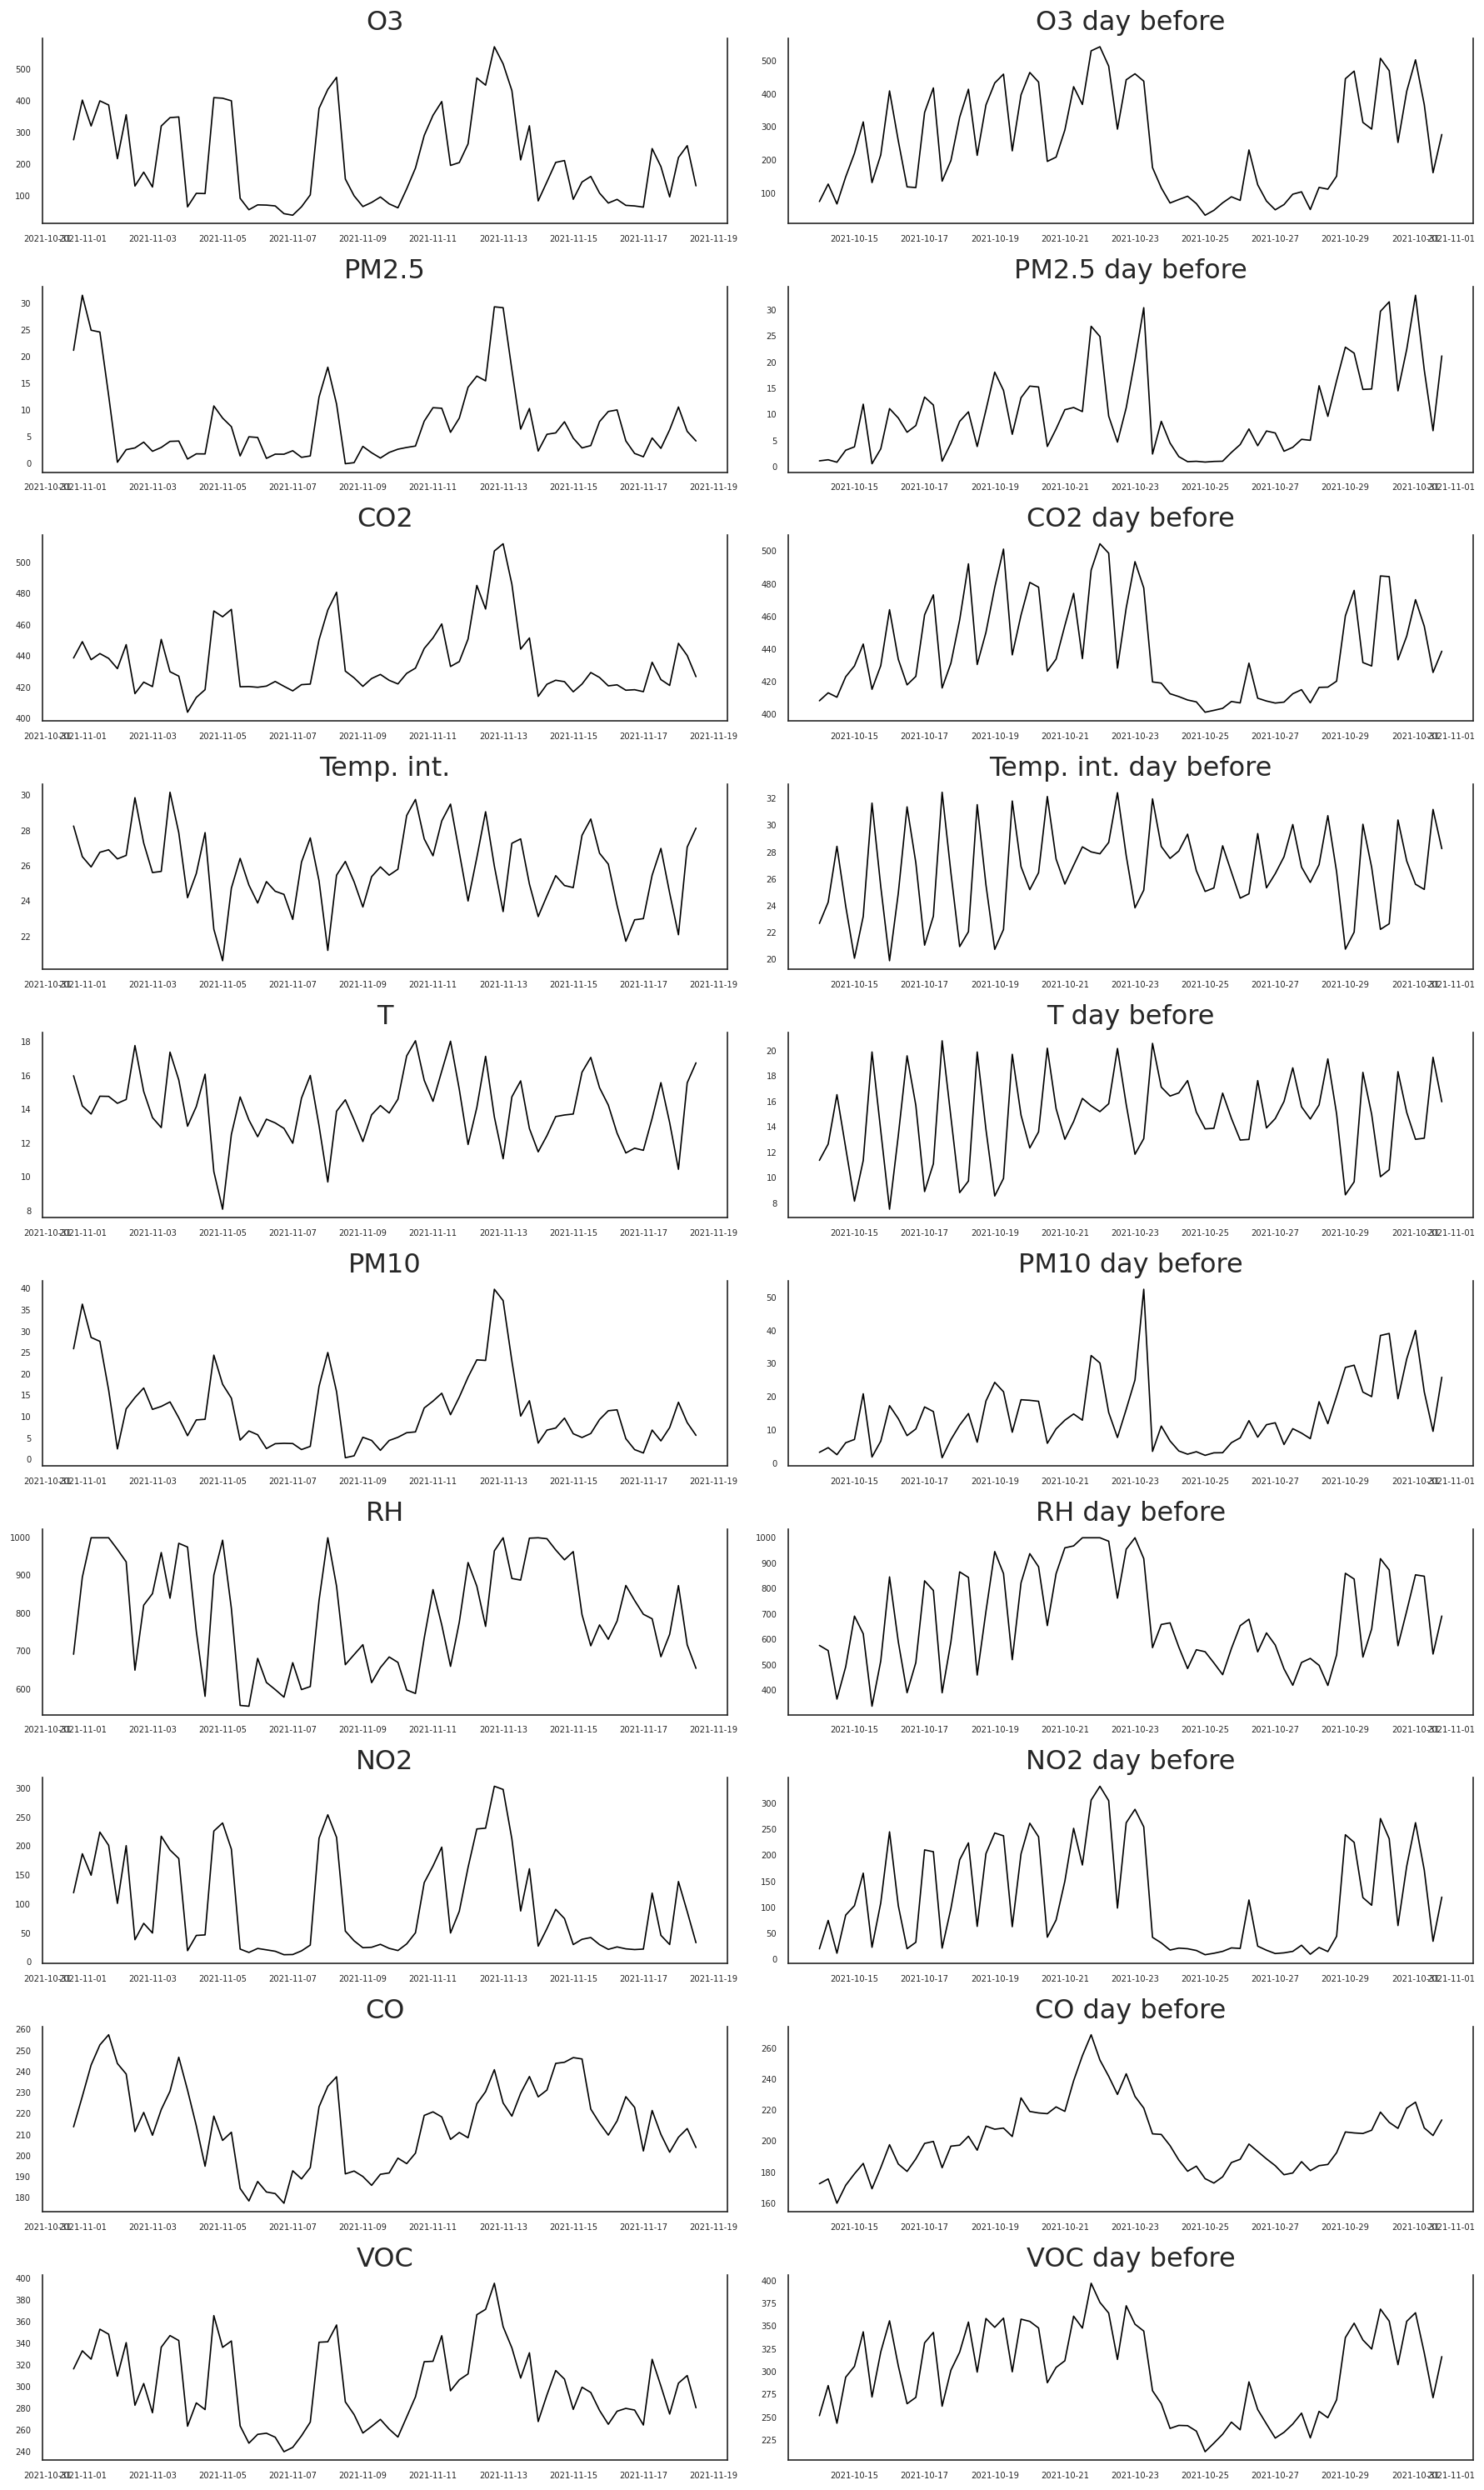

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
%matplotlib inline

# Plot
fig, axes = plt.subplots(nrows=10, ncols=2, dpi=120, figsize=(15,25))
for i, ax in enumerate(axes.flatten()):
    if(i%2==0):
      data_maha = data[df.columns[i/2]]
      ax.plot(data_maha, color='black', linewidth=1)
      
      # x axis value list.
      x_number_list_l = list(anomalies_l.index.values)
      # y axis value list.
      y_number_list_l = list(anomalies_l[df.columns[i/2]].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_l, y_number_list_l, color='green', s=10)

      # x axis value list.
      x_number_list_m = list(anomalies_m.index.values)
      # y axis value list.
      y_number_list_m = list(anomalies_m[df.columns[i/2]].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_m, y_number_list_m, color='orange', s=10)

      # x axis value list.
      x_number_list_h = list(anomalies_h.index.values)
      # y axis value list.
      y_number_list_h = list(anomalies_h[df.columns[i/2]].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_h, y_number_list_h, color='red', s=10)

      # Decorations
      ax.set_title(df.columns[i/2])
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=6)
    else:
      data_before = day_before[df.columns[(i-1)/2]]
      ax.plot(data_before, color='black', linewidth=1)
      # Decorations
      ax.set_title(df.columns[(i-1)/2]+' day before')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=6)

plt.tight_layout();


# Searching the anomalies using distance from the var model expected values

In [5]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(ts_data, column='', signif=0.05, series=False):
    if series:
        adf_test = adfuller(ts_data, autolag='AIC')
    else:
        adf_test = adfuller(ts_data[column], autolag='AIC')
    p_value = adf_test[1]                   
    if p_value <= signif:
        test_result = "Stationary"
    else:
        test_result = "Non-Stationary"
    return test_result

adf_test_results = {
    col: test_stationarity(df_d, col)
    for col in df_d.columns
}
adf_test_results     

{'CO': 'Stationary',
 'CO2': 'Stationary',
 'NO2': 'Stationary',
 'O3': 'Stationary',
 'PM10': 'Stationary',
 'PM2.5': 'Stationary',
 'RH': 'Stationary',
 'T': 'Stationary',
 'Temp. int.': 'Stationary',
 'VOC': 'Stationary'}

Use the differencing only on the variables that need it 

In [4]:
def differencing(data, column, order):
    differenced_data = data[column].diff(order)
    differenced_data.fillna(differenced_data.mean(), inplace=True)
    return differenced_data
for col in ['T', 'Temp. int.', 'NO2']:
    df_d[col] = differencing(df_d, col, 1)

Make a different var model for better results 

In [6]:
from statsmodels.tsa.api import VAR
max_lag_d = 15
var_model_d = VAR(df_d)
# select the best lag order
lag_results_d = var_model_d.select_order(max_lag_d)
selected_lag_d = lag_results_d.aic
print(selected_lag_d)

5


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [7]:
var_d = VAR(df_d)
var_fitresults_d = var_d.fit(selected_lag_d)
var_fit_df_d=pd.DataFrame(var_fitresults_d.fittedvalues, index=df_copy.index[selected_lag_d:], columns=df_d.columns)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Revert the differencing

In [8]:
how_many_diff=168
synch=3
res=pd.DataFrame(index=df_copy.index[-how_many_diff:], columns=df_d.columns)
how_many_times=how_many_diff/synch
allvalues=[]
for col in ['T','Temp. int.', 'NO2']:
  for i in range(int(how_many_times)):
    if(i==how_many_times-1):
      x, x_diff = df_copy[col].iloc[-(how_many_diff+1)+(i*synch):-how_many_diff+(i*synch)], var_fit_df_d[col].iloc[-how_many_diff+(i*synch):]
    else:
      x, x_diff = df_copy[col].iloc[-(how_many_diff+1)+(i*synch):-how_many_diff+(i*synch)], var_fit_df_d[col].iloc[-how_many_diff+(i*synch):-how_many_diff+(i*synch)+synch]
    temp=np.r_[x, x_diff].cumsum()
    allvalues.extend(temp[-synch:])
res['T']=allvalues[0:how_many_diff]
res['Temp. int.']=allvalues[how_many_diff:how_many_diff*2]
res['NO2']=allvalues[how_many_diff*2:]

Add the ones that were not differenced

In [9]:
for col in df_d.columns.difference(['T', 'Temp. int.','NO2']):
  res[col]=var_fit_df_d[col]

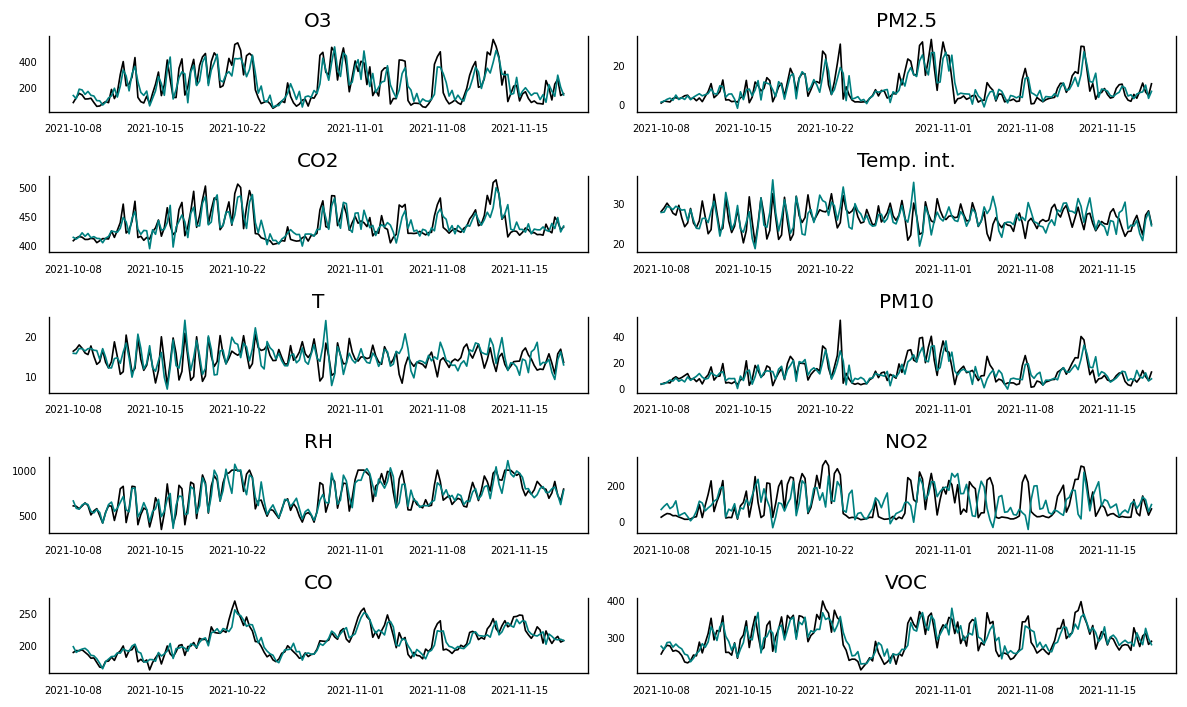

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

to_show=168
df_compare=df_copy.iloc[-to_show:,:]
res_compare=res.iloc[-to_show:,:]
# Plot
fig, axes = plt.subplots(nrows=5, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data_2 = df_compare[df.columns[i]]
    data_res=res_compare[res.columns[i]]
    ax.plot(data_2, color='black', linewidth=1)
    ax.plot(data_res, color='teal', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [11]:
res_index=res.index
temp_index=[]
for i in range(len(res_index)):
  if(i%synch==0):
    temp_index.append(res_index[i])

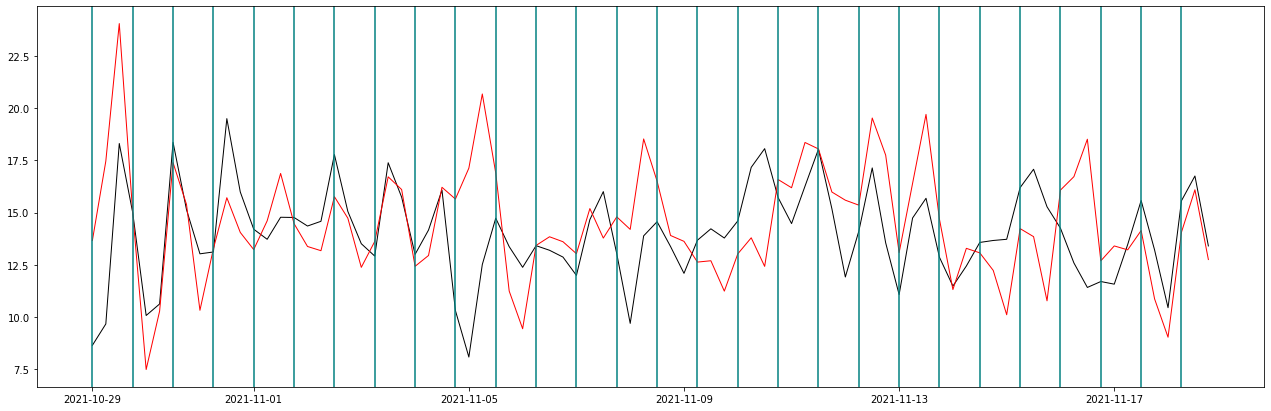

In [27]:
data_T = df_compare['T']
data_close_res=res_compare['T']
plt.figure(figsize=(22, 7))
plt.plot(data_T.iloc[int(to_show/2):], color='black', linewidth=1)
plt.plot(data_close_res.iloc[int(to_show/2):], color='red', linewidth=1)
for i in range(28):
  plt.axvline(temp_index[i+28]	, color='teal')
plt.show()

Find distance between predicted values and actual values

In [ ]:
import numpy as np
how_many_distance=how_many_diff
distance = pd.DataFrame(index=df_copy.iloc[-how_many_distance:,:].index)
usable = df_copy.iloc[-how_many_distance:,:]
for col in df.columns:
  distance[col]=abs((usable[col]).values-(res[col]).values)

# Testing the distance's distributions and finding the thresholds

Make histograms

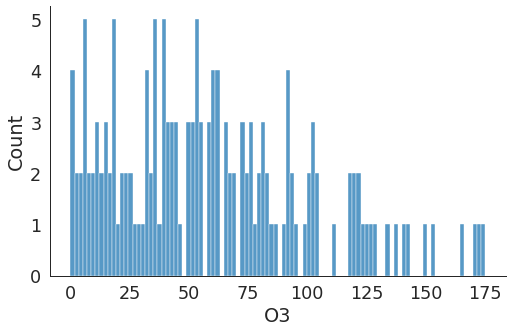

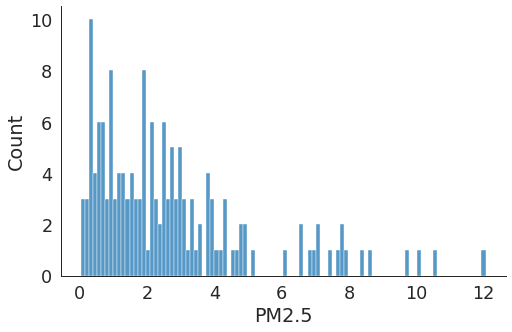

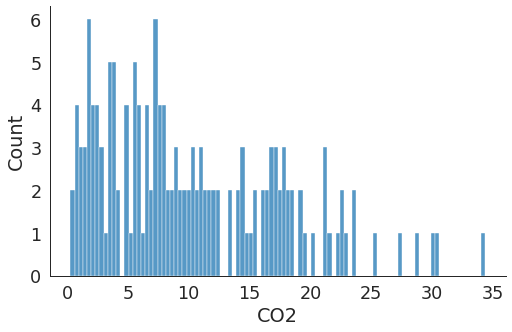

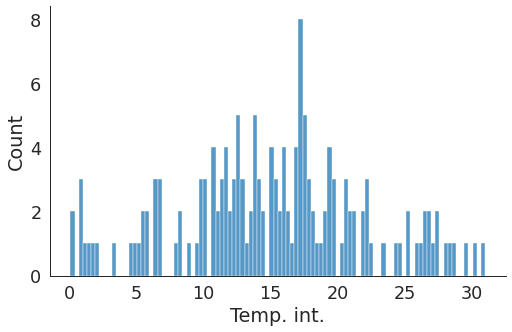

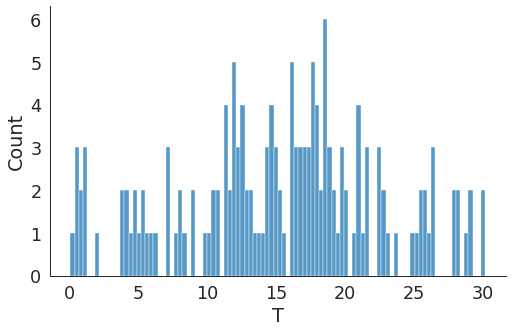

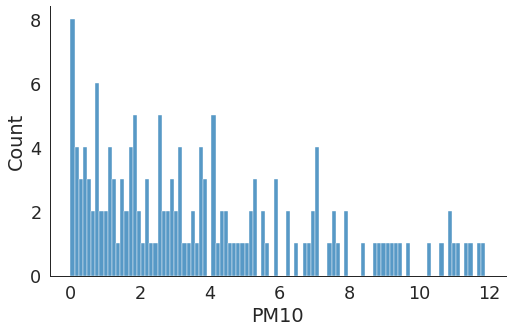

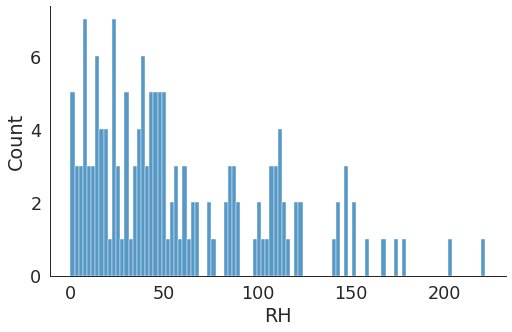

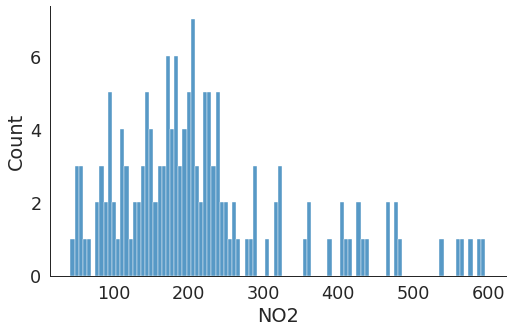

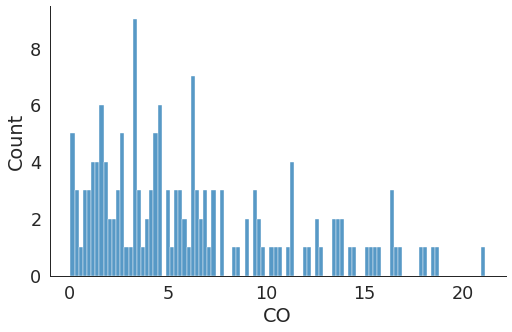

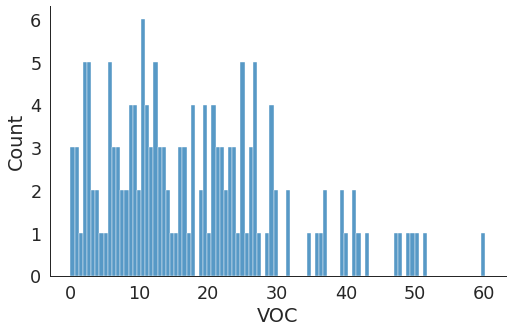

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions
import scipy.stats as stats


#remove outliers
z_scores = stats.zscore(distance)

abs_z_scores = np.abs(z_scores)
filtered_distance = (abs_z_scores < 3).all(axis=1)
new_distance = distance[filtered_distance]

for col in df.columns:
  sns.set_style('white')
  sns.set_context("paper", font_scale = 2)
  sns.displot(data=new_distance, x=col, kind="hist", bins = 100, aspect = 1.5)

Find the best distribution (the output ranks the best distributions in ascending order)

          sumsquare_error          aic          bic  kl_div
burr             0.001639  1110.495623 -1768.084563     inf
triang           0.001683  1079.106370 -1768.999114     inf
beta             0.001704  1089.154880 -1762.021577     inf
gamma            0.001839  1109.189898 -1755.217621     inf
pearson3         0.001839  1109.189959 -1755.217578     inf


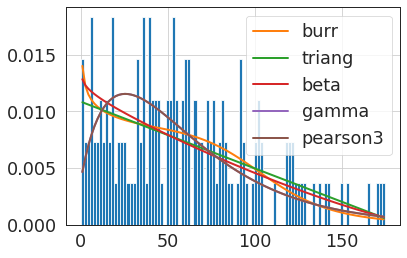

In [ ]:
dis = new_distance["O3"].values
O3_min=min(dis)
O3_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
burr_param_O=f.fitted_param["burr"]

threshold_O3 low: 143.98664638773764
threshold_O3 med: 152.86873079778928
threshold_O3 high: 165.7564611182564


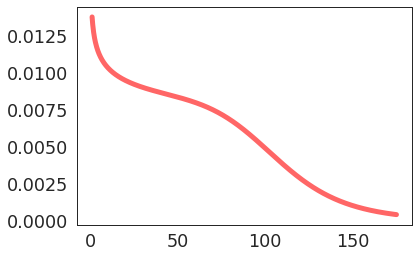

In [ ]:
from scipy.stats import burr
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)

c, d = burr_param_O[0], burr_param_O[1]
loc, scale = burr_param_O[2], burr_param_O[3]

#graph to test if the parameters are correct
x = np.linspace(O3_min+1,O3_max, 1000)
ax.plot(x, burr.pdf(x, c, d, loc, scale),
       'r-', lw=5, alpha=0.6)

# using the cdf
found=0
for i in x:
  if ((burr.cdf(i,c, d, loc, scale)>0.96) & (found<1)):
    threshold_O3_l=i
    found=1
  if ((burr.cdf(i,c, d, loc, scale)>0.97) & (found<2)):
    threshold_O3_m=i
    found=2
  if ((burr.cdf(i,c, d, loc, scale)>0.98) & (found<3)):
    threshold_O3_h=i
    found=3
print('threshold_O3 low: '+str(threshold_O3_l))
print('threshold_O3 med: '+str(threshold_O3_m))
print('threshold_O3 high: '+str(threshold_O3_h))



             sumsquare_error         aic         bic  kl_div
gamma               0.420401  665.262367 -907.809284     inf
pearson3            0.420402  665.266603 -907.808646     inf
weibull_min         0.424316  665.796625 -906.363248     inf
burr                0.430820  694.746877 -898.940085     inf
invgauss            0.455017  669.027079 -895.465412     inf


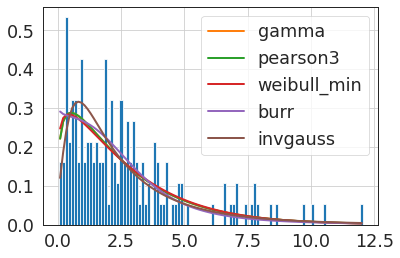

In [ ]:
dis = new_distance["PM2.5"].values
PM2_min=min(dis)
PM2_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
gamma_param_P=f.fitted_param["gamma"]

threshold_PM2 low: 7.941903161904536
threshold_PM2 med: 8.591569043371035
threshold_PM2 high: 9.517944466943634


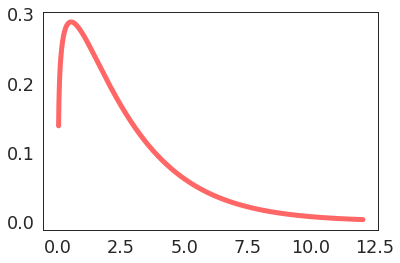

In [ ]:
from scipy.stats import gamma
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)

a = gamma_param_P[0]
loc, scale = gamma_param_P[1], gamma_param_P[2]

#graph to test if the parameters are correct
x = np.linspace(PM2_min,PM2_max, 1000)
ax.plot(x, gamma.pdf(x, a, loc, scale),
       'r-', lw=5, alpha=0.6)

# using the cdf
found=0
for i in x:
  if ((gamma.cdf(i,a, loc, scale)>0.96) & (found<1)):
    threshold_PM2_l=i
    found=1
  if ((gamma.cdf(i,a, loc, scale)>0.97) & (found<2)):
    threshold_PM2_m=i
    found=2
  if ((gamma.cdf(i,a, loc, scale)>0.98) & (found<3)):
    threshold_PM2_h=i
    found=3
print('threshold_PM2 low: '+str(threshold_PM2_l))
print('threshold_PM2 med: '+str(threshold_PM2_m))
print('threshold_PM2 high: '+str(threshold_PM2_h))


          sumsquare_error         aic          bic  kl_div
beta             0.039360  803.233274 -1272.239489     inf
gamma            0.041625  809.337261 -1268.560600     inf
pearson3         0.041625  809.338001 -1268.560481     inf
triang           0.042795  762.512791 -1264.235459     inf
burr             0.043841  814.918907 -1255.418736     inf


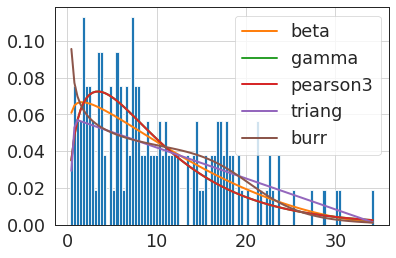

In [ ]:
dis = new_distance["CO2"].values
CO2_min=min(dis)
CO2_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
beta_param_CO2=f.fitted_param["beta"]

threshold_CO2 low: 25.683242128245134
threshold_CO2 med: 26.84247341264507
threshold_CO2 high: 28.3426550748097


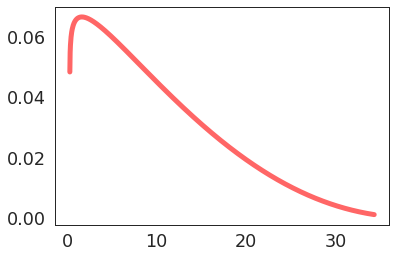

In [ ]:
from scipy.stats import beta
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)

c, d = beta_param_CO2[0], beta_param_CO2[1]
loc, scale = beta_param_CO2[2], beta_param_CO2[3]

#graph to test if the parameters are correct
x = np.linspace(CO2_min,CO2_max , 1000)
ax.plot(x, beta.pdf(x, c, d, loc, scale),
       'r-', lw=5, alpha=0.6)

# using the cdf
found=0
for i in x:
  if ((beta.cdf(i,c, d, loc, scale)>0.96) & (found<1)):
    threshold_CO2_l=i
    found=1
  if ((beta.cdf(i,c, d, loc, scale)>0.97) & (found<2)):
    threshold_CO2_m=i
    found=2
  if ((beta.cdf(i,c, d, loc, scale)>0.98) & (found<3)):
    threshold_CO2_h=i
    found=3
print('threshold_CO2 low: '+str(threshold_CO2_l))
print('threshold_CO2 med: '+str(threshold_CO2_m))
print('threshold_CO2 high: '+str(threshold_CO2_h))


          sumsquare_error         aic          bic  kl_div
pearson3         0.067638  743.507078 -1192.828337     inf
norm             0.067639  741.370024 -1197.874940     inf
gamma            0.067653  743.285790 -1192.792136     inf
lognorm          0.067681  743.153927 -1192.728309     inf
burr             0.068242  742.152829 -1186.390283     inf


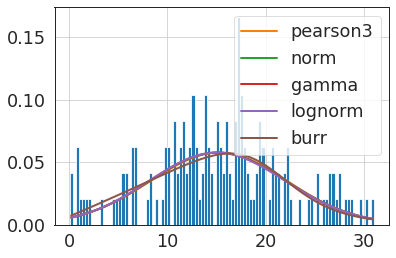

In [ ]:
dis = new_distance["Temp. int."].values
Temp_min=min(dis)
Temp_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
beta_param_Temp= f.fitted_param["beta"]

threshold_Temp low: 0.37561654936712985
threshold_Temp med: 0.40530069361716875
threshold_Temp high: 0.44626481268222246


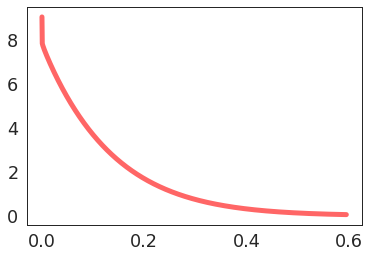

In [ ]:
from scipy.stats import beta
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)

a, b = beta_param_Temp[0], beta_param_Temp[1]
loc, scale = beta_param_Temp[2], beta_param_Temp[3]

#graph to test if the parameters are correct
x = np.linspace(Temp_min, Temp_max, 1000)
ax.plot(x, beta.pdf(x, a, b, loc, scale),
       'r-', lw=5, alpha=0.6)

# using the cdf
found=0
for i in x:
  if ((beta.cdf(i,a,b, loc, scale)>0.96) & (found<1)):
    threshold_Temp_l=i
    found=1
  if ((beta.cdf(i,a,b, loc, scale)>0.97) & (found<2)):
    threshold_Temp_m=i
    found=2
  if ((beta.cdf(i,a,b, loc, scale)>0.98) & (found<3)):
    threshold_Temp_h=i
    found=3
print('threshold_Temp low: '+str(threshold_Temp_l))
print('threshold_Temp med: '+str(threshold_Temp_m))
print('threshold_Temp high: '+str(threshold_Temp_h))


          sumsquare_error         aic          bic  kl_div
triang           0.070852  715.636425 -1185.585529     inf
pearson3         0.072065  730.065835 -1182.938166     inf
norm             0.072842  727.625034 -1186.314735     inf
lognorm          0.073103  729.825811 -1180.706346     inf
gamma            0.073402  729.188115 -1180.069431     inf


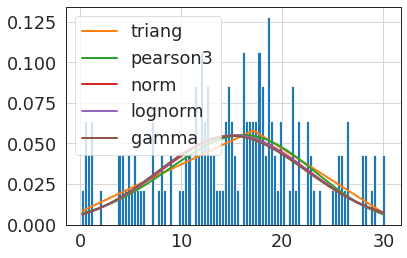

In [ ]:
dis = new_distance["T"].values
T_min=min(dis)
T_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
beta_param_T=f.fitted_param["beta"]

hello
threshold_T low: 0.35178276569856726
threshold_T med: 0.3672618828840767
threshold_T high: 0.38638314528970596


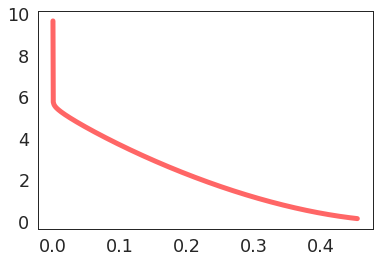

In [ ]:
from scipy.stats import beta
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)

a, b = beta_param_T[0], beta_param_T[1]
loc, scale = beta_param_T[2], beta_param_T[3]

#graph to test if the parameters are correct
x = np.linspace(T_min, T_max, 1000)
ax.plot(x, beta.pdf(x, a, b, loc, scale),
       'r-', lw=5, alpha=0.6)

# using the cdf
found=0
for i in x:
  if ((beta.cdf(i,a, b, loc, scale)>0.96) & (found<1)):
    print('hello')
    threshold_T_l=i
    found=1
  if ((beta.cdf(i,a, b, loc, scale)>0.97) & (found<2)):
    threshold_T_m=i
    found=2
  if ((beta.cdf(i,a, b, loc, scale)>0.98) & (found<3)):
    threshold_T_h=i
    found=3
print('threshold_T low: '+str(threshold_T_l))
print('threshold_T med: '+str(threshold_T_m))
print('threshold_T high: '+str(threshold_T_h))


          sumsquare_error         aic         bic  kl_div
beta             0.352918  561.951428 -930.055003     inf
burr             0.354381  559.355248 -929.409759     inf
gamma            0.382950  584.785202 -922.364709     inf
pearson3         0.383076  583.824227 -922.313487     inf
expon            0.384649  581.921664 -926.723848     inf


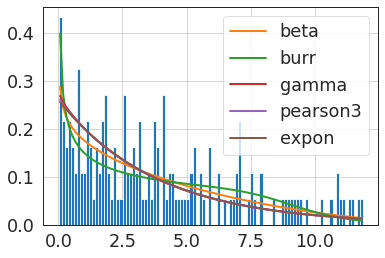

In [ ]:
dis = new_distance["PM10"].values
PM10_min=min(dis)
PM10_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
burr_param_PM10=f.fitted_param["burr"]

threshold_PM10 low: 10.044187703276354
threshold_PM10 med: 10.488097819133587
threshold_PM10 high: 11.107235612302887


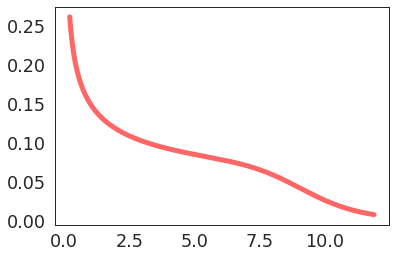

In [ ]:
from scipy.stats import burr
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)

c, d = burr_param_PM10[0], burr_param_PM10[1]
loc, scale = burr_param_PM10[2], burr_param_PM10[3]

#graph to test if the parameters are correct
x = np.linspace(PM10_min+0.2, PM10_max, 1000)
ax.plot(x, burr.pdf(x, c, d, loc, scale),
       'r-', lw=5, alpha=0.6)

# using the cdf
found=0
for i in x:
  if ((burr.cdf(i,c, d, loc, scale)>0.96) & (found<1)):
    threshold_PM10_l=i
    found=1
  if ((burr.cdf(i,c, d, loc, scale)>0.97) & (found<2)):
    threshold_PM10_m=i
    found=2
  if ((burr.cdf(i,c, d, loc, scale)>0.98) & (found<3)):
    threshold_PM10_h=i
    found=3
print('threshold_PM10 low: '+str(threshold_PM10_l))
print('threshold_PM10 med: '+str(threshold_PM10_m))
print('threshold_PM10 high: '+str(threshold_PM10_h))


          sumsquare_error          aic          bic  kl_div
gamma            0.001298  1201.451535 -1809.598871     inf
pearson3         0.001298  1201.451567 -1809.598863     inf
beta             0.001302  1193.444146 -1804.040722     inf
expon            0.001370  1197.205823 -1806.229068     inf
invgauss         0.001390  1211.080714 -1798.844645     inf


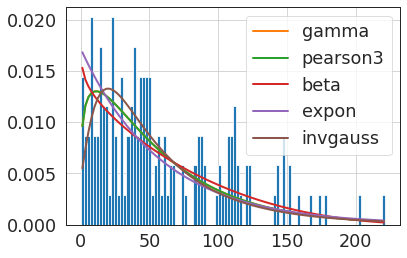

In [ ]:
dis = new_distance["RH"].values
RH_min=min(dis)
RH_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
gamma_param_RH=f.fitted_param["gamma"]

threshold_RH low: 173.49801659675785
threshold_RH med: 187.90973286003435
threshold_RH high: 207.8644169168787


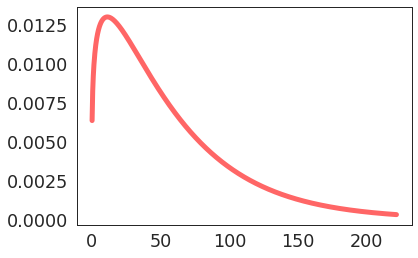

In [ ]:
from scipy.stats import gamma
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)

a = gamma_param_RH[0]
loc, scale = gamma_param_RH[1], gamma_param_RH[2]

#graph to test if the parameters are correct
x = np.linspace(RH_min, RH_max, 1000)
ax.plot(x, gamma.pdf(x, a, loc, scale),
       'r-', lw=5, alpha=0.6)

# using the cdf
found=0
for i in x:
  if ((gamma.cdf(i,a, loc, scale)>0.96) & (found<1)):
    threshold_RH_l=i
    found=1
  if ((gamma.cdf(i,a, loc, scale)>0.97) & (found<2)):
    threshold_RH_m=i
    found=2
  if ((gamma.cdf(i,a, loc, scale)>0.98) & (found<3)):
    threshold_RH_h=i
    found=3
print('threshold_RH low: '+str(threshold_RH_l))
print('threshold_RH med: '+str(threshold_RH_m))
print('threshold_RH high: '+str(threshold_RH_h))


          sumsquare_error          aic          bic  kl_div
burr             0.000174  1384.591883 -2118.323692     inf
lognorm          0.000187  1368.388589 -2111.808609     inf
invgauss         0.000189  1365.498224 -2109.853486     inf
pearson3         0.000194  1360.744900 -2105.975123     inf
gamma            0.000194  1360.744953 -2105.975109     inf


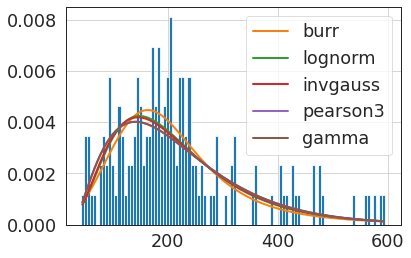

In [ ]:
dis = new_distance["NO2"].values
NO2_min=min(dis)
NO2_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
burr_param_NO2=f.fitted_param["burr"]

threshold_NO2 low: 488.4008161168078
threshold_NO2 med: 531.070823230715
threshold_NO2 high: 559.8869319310159


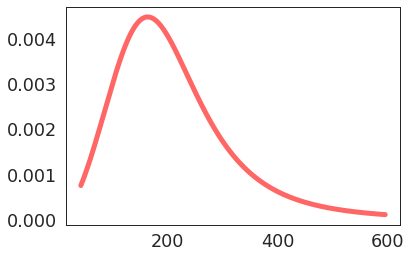

In [ ]:
from scipy.stats import burr
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)

c, d = burr_param_NO2[0], burr_param_NO2[1]
loc, scale = burr_param_NO2[2], burr_param_NO2[3]

#graph to test if the parameters are correct
x = np.linspace(NO2_min, NO2_max, 1000)
ax.plot(x, burr.pdf(x, c, d, loc, scale),
       'r-', lw=5, alpha=0.6)

# using the cdf
found=0
for i in x:
  if ((burr.cdf(i,c, d, loc, scale)>0.96) & (found<1)):
    threshold_NO2_l=i
    found=1
  if ((burr.cdf(i,c, d, loc, scale)>0.97) & (found<2)):
    threshold_NO2_m=i
    found=2
  if ((burr.cdf(i,c, d, loc, scale)>0.975) & (found<3)):
    threshold_NO2_h=i
    found=3
print('threshold_NO2 low: '+str(threshold_NO2_l))
print('threshold_NO2 med: '+str(threshold_NO2_m))
print('threshold_NO2 high: '+str(threshold_NO2_h))


          sumsquare_error         aic          bic  kl_div
gamma            0.171352  705.657716 -1047.817901     inf
pearson3         0.171352  705.658282 -1047.817643     inf
beta             0.173644  691.942297 -1040.695216     inf
invgauss         0.176819  714.807699 -1042.918112     inf
lognorm          0.177593  717.425073 -1042.236467     inf


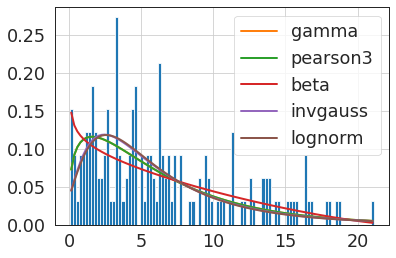

In [ ]:
dis = new_distance["CO"].values
CO_min=min(dis)
CO_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
gamma_param_CO=f.fitted_param["gamma"]

threshold_CO low: 18.503273518808435
threshold_CO med: 19.98173888483493
threshold_CO high: 20.911059972051582


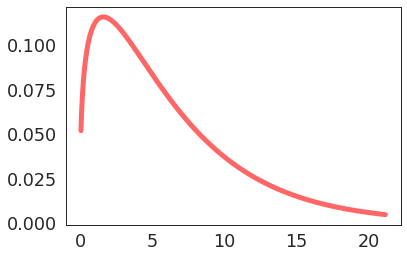

In [ ]:
from scipy.stats import gamma
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)

c= gamma_param_CO[0]
loc, scale = gamma_param_CO[1], gamma_param_CO[2]

#graph to test if the parameters are correct
x = np.linspace(CO_min, CO_max, 1000)
ax.plot(x, gamma.pdf(x, c, loc, scale),
       'r-', lw=5, alpha=0.6)

# using the cdf
found=0
for i in x:
  if ((gamma.cdf(i,c, loc, scale)>0.96) & (found<1)):
    threshold_CO_l=i
    found=1
  if ((gamma.cdf(i,c, loc, scale)>0.97) & (found<2)):
    threshold_CO_m=i
    found=2
  if ((gamma.cdf(i,c, loc, scale)>0.975) & (found<3)):
    threshold_CO_h=i
    found=3
print('threshold_CO low: '+str(threshold_CO_l))
print('threshold_CO med: '+str(threshold_CO_m))
print('threshold_CO high: '+str(threshold_CO_h))


          sumsquare_error         aic          bic  kl_div
beta             0.015306  916.418085 -1419.578598     inf
burr             0.015508  938.470599 -1417.535653     inf
gamma            0.016111  921.355337 -1416.638458     inf
pearson3         0.016111  921.355512 -1416.638399     inf
triang           0.016391  875.329758 -1413.948698     inf


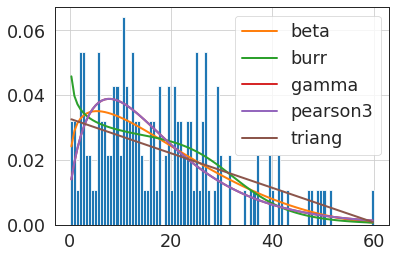

In [ ]:
dis = new_distance["VOC"].values
VOC_min=min(dis)
VOC_max=max(dis)
f = Fitter(dis,
           distributions=['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang','burr'])
f.fit()
print(f.summary())
burr_VOC=f.fitted_param["burr"]

threshold_VOC low: 42.413624953643605
threshold_VOC med: 44.815686218608846
threshold_VOC high: 48.238623521184316


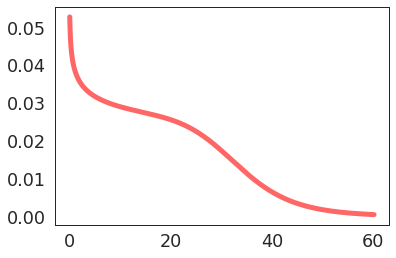

In [ ]:
from scipy.stats import burr
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)

c, d = burr_VOC[0], burr_VOC[1]
loc, scale = burr_VOC[2], burr_VOC[3]

#graph to test if the parameters are correct
x = np.linspace(VOC_min+0.1, VOC_max, 1000)
ax.plot(x, burr.pdf(x, c, d, loc, scale),
       'r-', lw=5, alpha=0.6)

# using the cdf
found=0
for i in x:
  if ((burr.cdf(i,c, d, loc, scale)>0.96) & (found<1)):
    threshold_VOC_l=i
    found=1
  if ((burr.cdf(i,c, d, loc, scale)>0.97) & (found<2)):
    threshold_VOC_m=i
    found=2
  if ((burr.cdf(i,c, d, loc, scale)>0.98) & (found<3)):
    threshold_VOC_h=i
    found=3
print('threshold_VOC low: '+str(threshold_VOC_l))
print('threshold_VOC med: '+str(threshold_VOC_m))
print('threshold_VOC high: '+str(threshold_VOC_h))


# Using the thresholds to search anomalies 

In [ ]:
def find_anomalies_thresholds(errors, threshold_low, threshold_med, threshold_high):
  predictions=pd.DataFrame(np.zeros((len(errors), 1)))
  for i in range(len(errors)):
    if((errors.iloc[i] >= threshold_low) &(errors.iloc[i] < threshold_med)):
      predictions.iloc[i]=1
    if((errors.iloc[i] >= threshold_med) &(errors.iloc[i]< threshold_high)):
      predictions.iloc[i]=2
    if(errors.iloc[i] >= threshold_high):
      predictions.iloc[i]=3
  return predictions

data_thresh=df_copy.iloc[-to_show:,:]

Finding anomalies with the burr distribution (O3)

In [ ]:
predictions_O3 = find_anomalies_thresholds(distance['O3'], threshold_O3_l, threshold_O3_m, threshold_O3_h)

data_thresh['Predictions_O3'] = predictions_O3.iloc[-to_show:,:].values
data_thresh['Predictions_O3'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    155
3.0      8
2.0      3
1.0      2
Name: Predictions_O3, dtype: int64

Finding anomalies with the burr distribution (PM2.5)

In [ ]:
predictions_PM2 = find_anomalies_thresholds(distance['PM2.5'], threshold_PM2_l, threshold_PM2_m, threshold_PM2_h)

data_thresh['Predictions_PM2.5'] = predictions_PM2.iloc[-to_show:,:].values
data_thresh['Predictions_PM2.5'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    156
3.0      9
2.0      2
1.0      1
Name: Predictions_PM2.5, dtype: int64

Finding anomalies with the burr distribution (CO2)

In [ ]:
predictions_CO2 = find_anomalies_thresholds(distance['CO2'], threshold_CO2_l, threshold_CO2_m, threshold_CO2_h)

data_thresh['Predictions_CO2'] = predictions_CO2.iloc[-to_show:,:].values
data_thresh['Predictions_CO2'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    156
3.0     10
1.0      1
2.0      1
Name: Predictions_CO2, dtype: int64

Finding anomalies with the beta distribution (Temp. int.)

In [ ]:
predictions_Temp = find_anomalies_thresholds(distance['Temp. int.'], threshold_Temp_l, threshold_Temp_m, threshold_Temp_h)

data_thresh['Predictions_Temp_int'] = predictions_Temp.iloc[-to_show:,:].values
data_thresh['Predictions_Temp_int'].value_counts()

Finding anomalies with the burr distribution (T)


In [ ]:
predictions_T = find_anomalies_thresholds(distance['T'], threshold_T_l, threshold_T_m, threshold_T_h)

data_thresh['Predictions_T'] = predictions_T.iloc[-to_show:,:].values
data_thresh['Predictions_T'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    137
3.0      6
1.0      1
Name: Predictions_T, dtype: int64

Finding anomalies with the burr distribution (PM10)

In [ ]:
predictions_PM10 = find_anomalies_thresholds(distance['PM10'], threshold_PM10_l, threshold_PM10_m, threshold_PM10_h)

data_thresh['Predictions_PM10'] = predictions_PM10.iloc[-to_show:,:].values
data_thresh['Predictions_PM10'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    151
3.0     10
2.0      6
1.0      1
Name: Predictions_PM10, dtype: int64

Finding anomalies with the burr distribution (RH)

In [ ]:
predictions_RH = find_anomalies_thresholds(distance['RH'], threshold_RH_l, threshold_RH_m, threshold_RH_h)

data_thresh['Predictions_RH'] = predictions_RH.iloc[-to_show:,:].values
data_thresh['Predictions_RH'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    160
3.0      4
1.0      2
2.0      2
Name: Predictions_RH, dtype: int64

Finding anomalies with the burr distribution (NO2)

In [ ]:
predictions_NO2 = find_anomalies_thresholds(distance['NO2'], threshold_NO2_l, threshold_NO2_m, threshold_NO2_h)

data_thresh['Predictions_NO2'] = predictions_NO2.iloc[-to_show:,:].values
data_thresh['Predictions_NO2'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    157
3.0      9
2.0      2
Name: Predictions_NO2, dtype: int64

Finding anomalies with the burr distribution (CO)

In [ ]:
predictions_CO = find_anomalies_thresholds(distance['CO'], threshold_CO_l, threshold_CO_m, threshold_CO_h)

data_thresh['Predictions_CO'] = predictions_CO.iloc[-to_show:,:].values
data_thresh['Predictions_CO'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    162
3.0      5
1.0      1
Name: Predictions_CO, dtype: int64

Finding anomalies with the beta distribution (VOC)

In [ ]:
predictions_VOC = find_anomalies_thresholds(distance['VOC'], threshold_VOC_l, threshold_VOC_m, threshold_VOC_h)

data_thresh['Predictions_VOC'] = predictions_VOC.iloc[-to_show:,:].values
data_thresh['Predictions_VOC'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.0    155
3.0      9
2.0      2
1.0      2
Name: Predictions_VOC, dtype: int64

# Showing the anomalies found with the prediction's distance with graphs

In [ ]:
to_show_res=72
show_res=res.iloc[-to_show_res:,:]
show_data_thresh=data_thresh.iloc[-to_show_res:,:]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


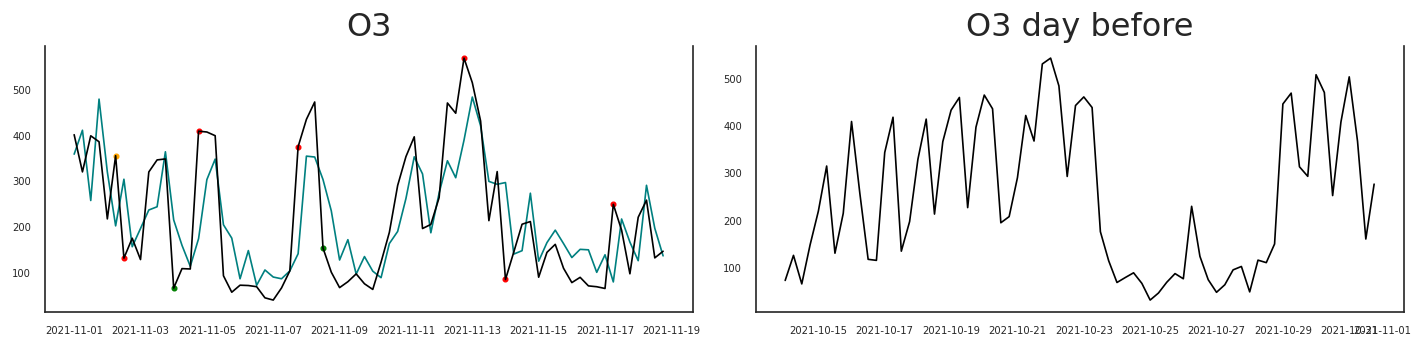

In [ ]:
anomalies_O3_l= show_data_thresh[(data_thresh['Predictions_O3'] == 1)]
anomalies_O3_m= show_data_thresh[(data_thresh['Predictions_O3'] == 2)]
anomalies_O3_h= show_data_thresh[(data_thresh['Predictions_O3'] == 3)]

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
%matplotlib inline

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=120, figsize=(12,3))
for i, ax in enumerate(axes.flatten()):
    if(i%2==0):
      data_res=show_res['O3']
      ax.plot(data_res, color='teal', linewidth=1)
      data_O3 = show_data_thresh['O3']
      ax.plot(data_O3, color='black', linewidth=1)
          
      # x axis value list.
      x_number_list_l = list(anomalies_O3_l.index.values)
      # y axis value list.
      y_number_list_l = list(anomalies_O3_l['O3'].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_l, y_number_list_l, color='green', s=8)

      # x axis value list.
      x_number_list_m = list(anomalies_O3_m.index.values)
      # y axis value list.
      y_number_list_m = list(anomalies_O3_m['O3'].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_m, y_number_list_m, color='orange', s=8)

      # x axis value list.
      x_number_list_h = list(anomalies_O3_h.index.values)
      # y axis value list.
      y_number_list_h = list(anomalies_O3_h['O3'].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_h, y_number_list_h, color='red', s=8)


      # Decorations
      ax.set_title('O3')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=6)
    else:
      data_before = day_before['O3']
      ax.plot(data_before, color='black', linewidth=1)
      # Decorations
      ax.set_title('O3 day before')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=6)

plt.tight_layout();

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


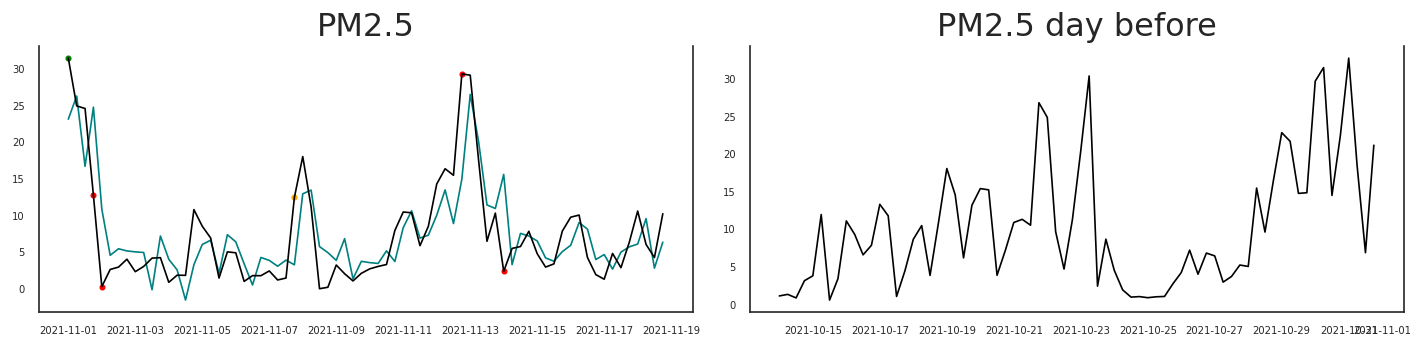

In [ ]:
anomalies_PM2_l= show_data_thresh[(data_thresh['Predictions_PM2.5'] == 1)]
anomalies_PM2_m= show_data_thresh[(data_thresh['Predictions_PM2.5'] == 2)]
anomalies_PM2_h= show_data_thresh[(data_thresh['Predictions_PM2.5'] == 3)]

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
%matplotlib inline

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=120, figsize=(12,3))
for i, ax in enumerate(axes.flatten()):
    if(i%2==0):
      data_res=show_res['PM2.5']
      ax.plot(data_res, color='teal', linewidth=1)
      data_PM2 = show_data_thresh['PM2.5']
      ax.plot(data_PM2, color='black', linewidth=1)
          
      # x axis value list.
      x_number_list_l = list(anomalies_PM2_l.index.values)
      # y axis value list.
      y_number_list_l = list(anomalies_PM2_l['PM2.5'].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_l, y_number_list_l, color='green', s=8)

      # x axis value list.
      x_number_list_m = list(anomalies_PM2_m.index.values)
      # y axis value list.
      y_number_list_m = list(anomalies_PM2_m['PM2.5'].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_m, y_number_list_m, color='orange', s=8)

      # x axis value list.
      x_number_list_h = list(anomalies_PM2_h.index.values)
      # y axis value list.
      y_number_list_h = list(anomalies_PM2_h['PM2.5'].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_h, y_number_list_h, color='red', s=8)

      # Decorations
      ax.set_title('PM2.5')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=6)
    else:
      data_before = day_before['PM2.5']
      ax.plot(data_before, color='black', linewidth=1)
      # Decorations
      ax.set_title('PM2.5 day before')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=6)

plt.tight_layout();

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


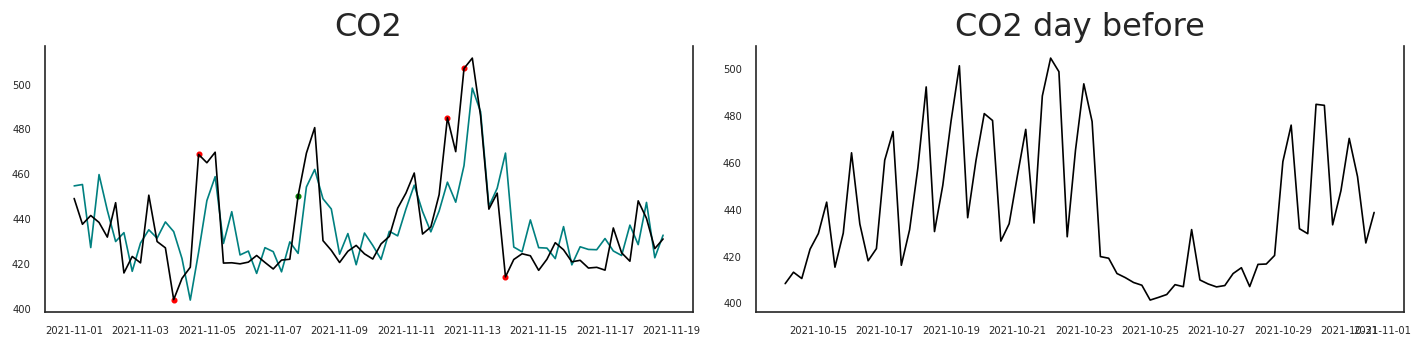

In [ ]:
anomalies_CO2_l= show_data_thresh[(data_thresh['Predictions_CO2'] == 1)]
anomalies_CO2_m= show_data_thresh[(data_thresh['Predictions_CO2'] == 2)]
anomalies_CO2_h= show_data_thresh[(data_thresh['Predictions_CO2'] == 3)]

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
%matplotlib inline

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=120, figsize=(12,3))
for i, ax in enumerate(axes.flatten()):
    if(i%2==0):
      data_res=show_res['CO2']
      ax.plot(data_res, color='teal', linewidth=1)
      data_CO2 = show_data_thresh['CO2']
      ax.plot(data_CO2, color='black', linewidth=1)
          
      # x axis value list.
      x_number_list_l = list(anomalies_CO2_l.index.values)
      # y axis value list.
      y_number_list_l = list(anomalies_CO2_l['CO2'].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_l, y_number_list_l, color='green', s=8)

      # x axis value list.
      x_number_list_m = list(anomalies_CO2_m.index.values)
      # y axis value list.
      y_number_list_m = list(anomalies_CO2_m['CO2'].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_m, y_number_list_m, color='orange', s=8)

      # x axis value list.
      x_number_list_h = list(anomalies_CO2_h.index.values)
      # y axis value list.
      y_number_list_h = list(anomalies_CO2_h['CO2'].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_h, y_number_list_h, color='red', s=8)

      # Decorations
      ax.set_title('CO2')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=6)
    else:
      data_before = day_before['CO2']
      ax.plot(data_before, color='black', linewidth=1)
      # Decorations
      ax.set_title('CO2 day before')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=6)

plt.tight_layout();

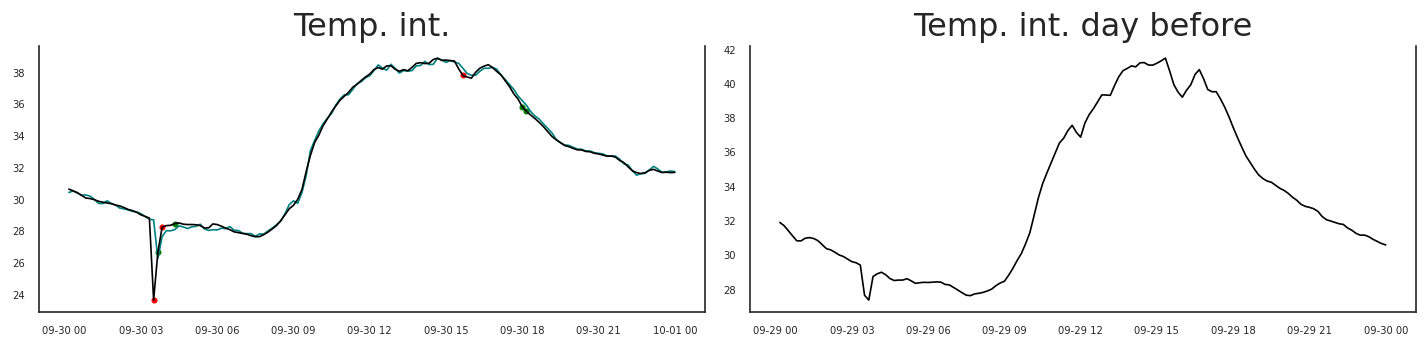

In [ ]:
anomalies_Temp_l= show_data_thresh[(data_thresh['Predictions_Temp_int'] == 1)]
anomalies_Temp_m= show_data_thresh[(data_thresh['Predictions_Temp_int'] == 2)]
anomalies_Temp_h= show_data_thresh[(data_thresh['Predictions_Temp_int'] == 3)]


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
%matplotlib inline

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=120, figsize=(12,3))
for i, ax in enumerate(axes.flatten()):
    if(i%2==0):
      data_res=show_data_thresh['Temp. int.']
      ax.plot(data_res, color='teal', linewidth=1)
      data_Temp = data_thresh['Temp. int.']
      ax.plot(data_Temp, color='black', linewidth=1)
          
      # x axis value list.
      x_number_list_l = list(anomalies_Temp_l.index.values)
      # y axis value list.
      y_number_list_l = list(anomalies_Temp_l['Temp. int.'].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_l, y_number_list_l, color='green', s=8)

      # x axis value list.
      x_number_list_m = list(anomalies_Temp_m.index.values)
      # y axis value list.
      y_number_list_m = list(anomalies_Temp_m['Temp. int.'].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_m, y_number_list_m, color='orange', s=8)

      # x axis value list.
      x_number_list_h = list(anomalies_Temp_h.index.values)
      # y axis value list.
      y_number_list_h = list(anomalies_Temp_h['Temp. int.'].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_h, y_number_list_h, color='red', s=8)

      # Decorations
      ax.set_title('Temp. int.')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=6)
    else:
      data_before = day_before['Temp. int.']
      ax.plot(data_before, color='black', linewidth=1)
      # Decorations
      ax.set_title('Temp. int. day before')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=6)

plt.tight_layout();

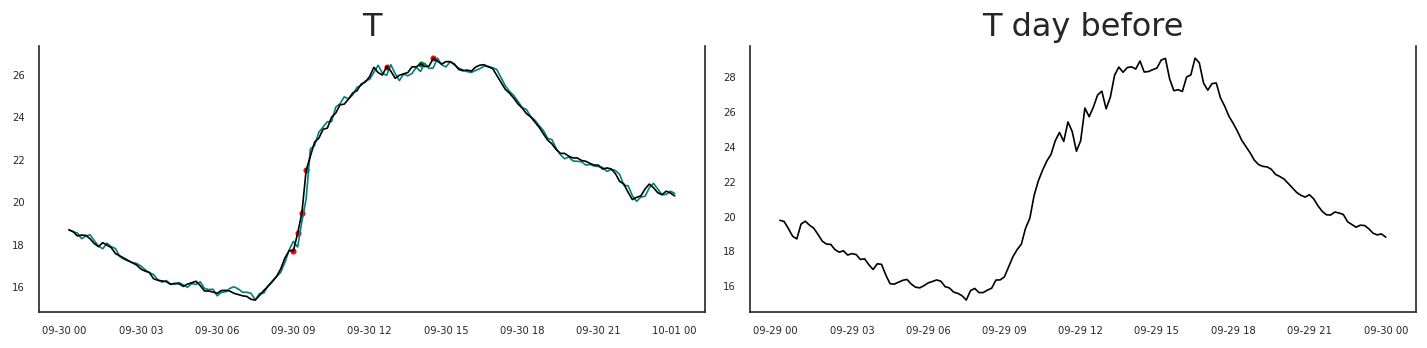

In [ ]:
anomalies_T_l= show_data_thresh[(data_thresh['Predictions_T'] == 1)]
anomalies_T_m= show_data_thresh[(data_thresh['Predictions_T'] == 2)]
anomalies_T_h= show_data_thresh[(data_thresh['Predictions_T'] == 3)]


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
%matplotlib inline

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=120, figsize=(12,3))
for i, ax in enumerate(axes.flatten()):
    if(i%2==0):
      data_res=show_res['T']
      ax.plot(data_res, color='teal', linewidth=1)
      data_T = show_data_thresh['T']
      ax.plot(data_T, color='black', linewidth=1)
          
      # x axis value list.
      x_number_list_l = list(anomalies_T_l.index.values)
      # y axis value list.
      y_number_list_l = list(anomalies_T_l['T'].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_l, y_number_list_l, color='green', s=8)

      # x axis value list.
      x_number_list_m = list(anomalies_T_m.index.values)
      # y axis value list.
      y_number_list_m = list(anomalies_T_m['T'].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_m, y_number_list_m, color='orange', s=8)

      # x axis value list.
      x_number_list_h = list(anomalies_T_h.index.values)
      # y axis value list.
      y_number_list_h = list(anomalies_T_h['T'].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_h, y_number_list_h, color='red', s=8)

      # Decorations
      ax.set_title('T')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=6)
    else:
      data_before = day_before['T']
      ax.plot(data_before, color='black', linewidth=1)
      # Decorations
      ax.set_title('T day before')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=6)

plt.tight_layout();

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


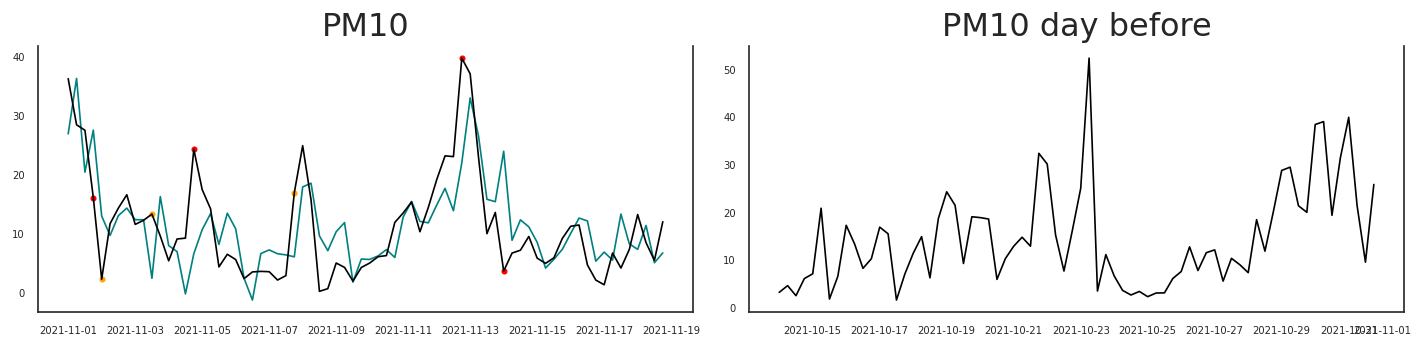

In [ ]:
anomalies_PM10_l= show_data_thresh[(data_thresh['Predictions_PM10'] == 1)]
anomalies_PM10_m= show_data_thresh[(data_thresh['Predictions_PM10'] == 2)]
anomalies_PM10_h= show_data_thresh[(data_thresh['Predictions_PM10'] == 3)]


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
%matplotlib inline

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=120, figsize=(12,3))
for i, ax in enumerate(axes.flatten()):
    if(i%2==0):
      data_res=show_res['PM10']
      ax.plot(data_res, color='teal', linewidth=1)
      data_PM10 = show_data_thresh['PM10']
      ax.plot(data_PM10, color='black', linewidth=1)
          
      # x axis value list.
      x_number_list_l = list(anomalies_PM10_l.index.values)
      # y axis value list.
      y_number_list_l = list(anomalies_PM10_l['PM10'].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_l, y_number_list_l, color='green', s=8)

      # x axis value list.
      x_number_list_m = list(anomalies_PM10_m.index.values)
      # y axis value list.
      y_number_list_m = list(anomalies_PM10_m['PM10'].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_m, y_number_list_m, color='orange', s=8)

      # x axis value list.
      x_number_list_h = list(anomalies_PM10_h.index.values)
      # y axis value list.
      y_number_list_h = list(anomalies_PM10_h['PM10'].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_h, y_number_list_h, color='red', s=8)

      # Decorations
      ax.set_title('PM10')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=6)
    else:
      data_before = day_before['PM10']
      ax.plot(data_before, color='black', linewidth=1)
      # Decorations
      ax.set_title('PM10 day before')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=6)

plt.tight_layout();

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


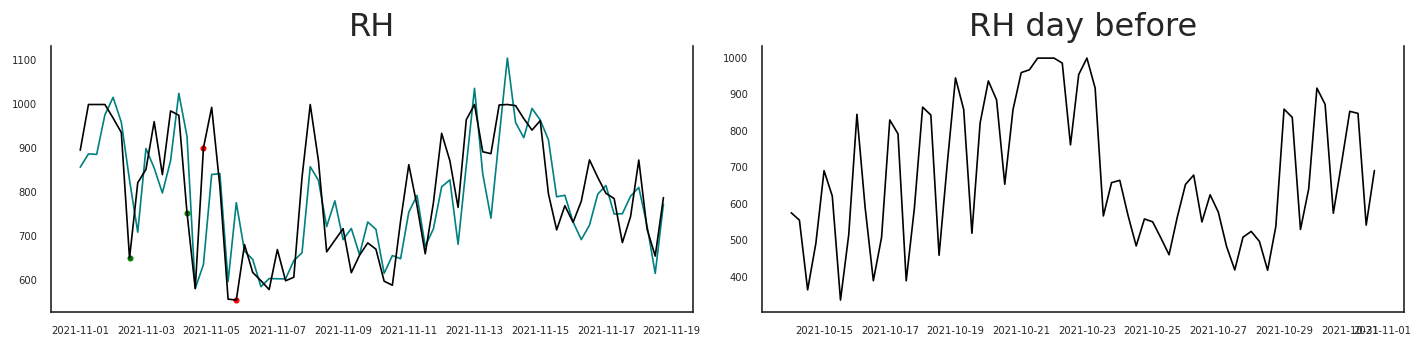

In [ ]:
anomalies_RH_l= show_data_thresh[(data_thresh['Predictions_RH'] == 1)]
anomalies_RH_m= show_data_thresh[(data_thresh['Predictions_RH'] == 2)]
anomalies_RH_h= show_data_thresh[(data_thresh['Predictions_RH'] == 3)]

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
%matplotlib inline

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=120, figsize=(12,3))
for i, ax in enumerate(axes.flatten()):
    if(i%2==0):
      data_res=show_res['RH']
      ax.plot(data_res, color='teal', linewidth=1)
      data_RH = show_data_thresh['RH']
      ax.plot(data_RH, color='black', linewidth=1)
          
      # x axis value list.
      x_number_list_l = list(anomalies_RH_l.index.values)
      # y axis value list.
      y_number_list_l = list(anomalies_RH_l['RH'].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_l, y_number_list_l, color='green', s=8)

      # x axis value list.
      x_number_list_m = list(anomalies_RH_m.index.values)
      # y axis value list.
      y_number_list_m = list(anomalies_RH_m['RH'].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_m, y_number_list_m, color='orange', s=8)

      # x axis value list.
      x_number_list_h = list(anomalies_RH_h.index.values)
      # y axis value list.
      y_number_list_h = list(anomalies_RH_h['RH'].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_h, y_number_list_h, color='red', s=8)

      # Decorations
      ax.set_title('RH')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=6)
    else:
      data_before = day_before['RH']
      ax.plot(data_before, color='black', linewidth=1)
      # Decorations
      ax.set_title('RH day before')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=6)

plt.tight_layout();

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


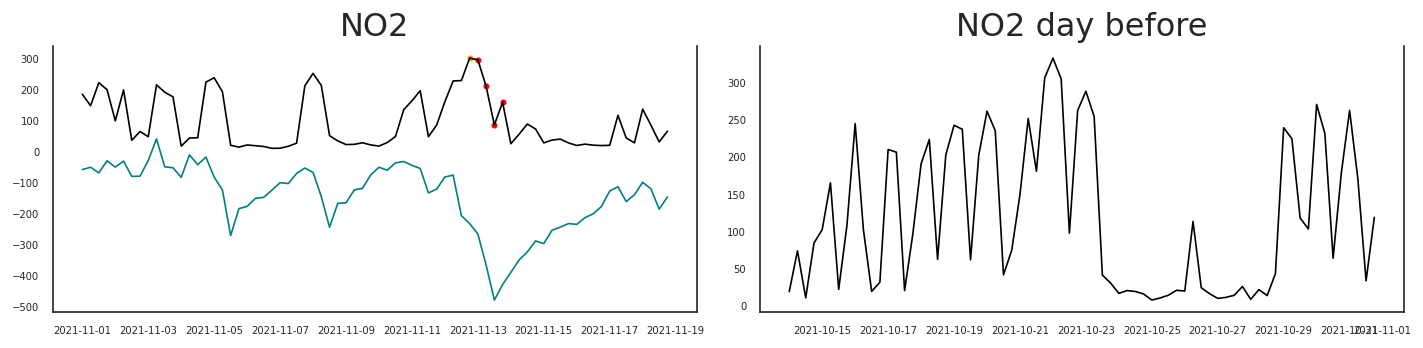

In [ ]:
anomalies_NO2_l= show_data_thresh[(data_thresh['Predictions_NO2'] == 1)]
anomalies_NO2_m= show_data_thresh[(data_thresh['Predictions_NO2'] == 2)]
anomalies_NO2_h= show_data_thresh[(data_thresh['Predictions_NO2'] == 3)]

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
%matplotlib inline

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=120, figsize=(12,3))
for i, ax in enumerate(axes.flatten()):
    if(i%2==0):
      data_res=show_res['NO2']
      ax.plot(data_res, color='teal', linewidth=1)
      data_NO2 = show_data_thresh['NO2']
      ax.plot(data_NO2, color='black', linewidth=1)
          
      # x axis value list.
      x_number_list_l = list(anomalies_NO2_l.index.values)
      # y axis value list.
      y_number_list_l = list(anomalies_NO2_l['NO2'].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_l, y_number_list_l, color='green', s=8)

      # x axis value list.
      x_number_list_m = list(anomalies_NO2_m.index.values)
      # y axis value list.
      y_number_list_m = list(anomalies_NO2_m['NO2'].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_m, y_number_list_m, color='orange', s=8)

      # x axis value list.
      x_number_list_h = list(anomalies_NO2_h.index.values)
      # y axis value list.
      y_number_list_h = list(anomalies_NO2_h['NO2'].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_h, y_number_list_h, color='red', s=8)


      # Decorations
      ax.set_title('NO2')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=6)
    else:
      data_before = day_before['NO2']
      ax.plot(data_before, color='black', linewidth=1)
      # Decorations
      ax.set_title('NO2 day before')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=6)

plt.tight_layout();

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


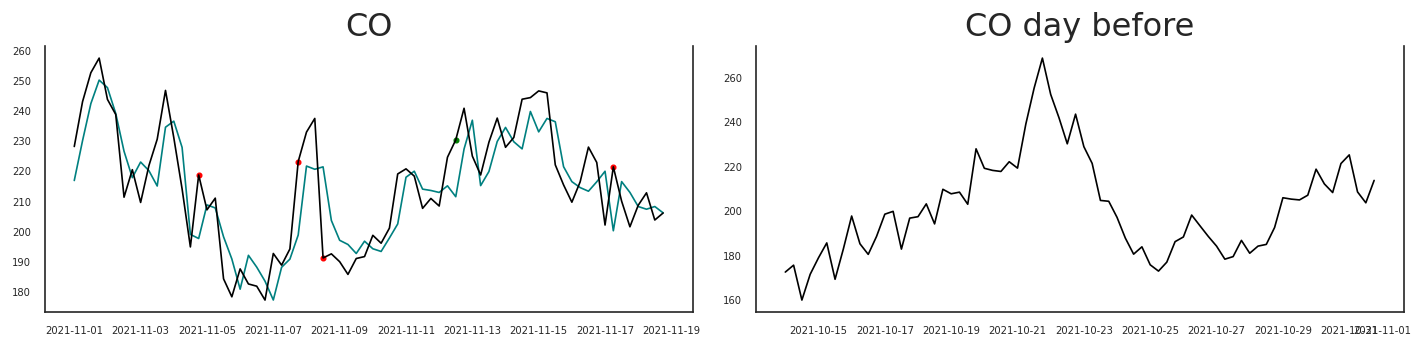

In [ ]:
anomalies_CO_l= show_data_thresh[(data_thresh['Predictions_CO'] == 1)]
anomalies_CO_m= show_data_thresh[(data_thresh['Predictions_CO'] == 2)]
anomalies_CO_h= show_data_thresh[(data_thresh['Predictions_CO'] == 3)]

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
%matplotlib inline

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=120, figsize=(12,3))
for i, ax in enumerate(axes.flatten()):
    if(i%2==0):
      data_res=show_res['CO']
      ax.plot(data_res, color='teal', linewidth=1)
      data_CO = show_data_thresh['CO']
      ax.plot(data_CO, color='black', linewidth=1)
          
      # x axis value list.
      x_number_list_l = list(anomalies_CO_l.index.values)
      # y axis value list.
      y_number_list_l = list(anomalies_CO_l['CO'].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_l, y_number_list_l, color='green', s=8)

      # x axis value list.
      x_number_list_m = list(anomalies_CO_m.index.values)
      # y axis value list.
      y_number_list_m = list(anomalies_CO_m['CO'].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_m, y_number_list_m, color='orange', s=8)

      # x axis value list.
      x_number_list_h = list(anomalies_CO_h.index.values)
      # y axis value list.
      y_number_list_h = list(anomalies_CO_h['CO'].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_h, y_number_list_h, color='red', s=8)


      # Decorations
      ax.set_title('CO')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=6)
    else:
      data_before = day_before['CO']
      ax.plot(data_before, color='black', linewidth=1)
      # Decorations
      ax.set_title('CO day before')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=6)

plt.tight_layout();

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


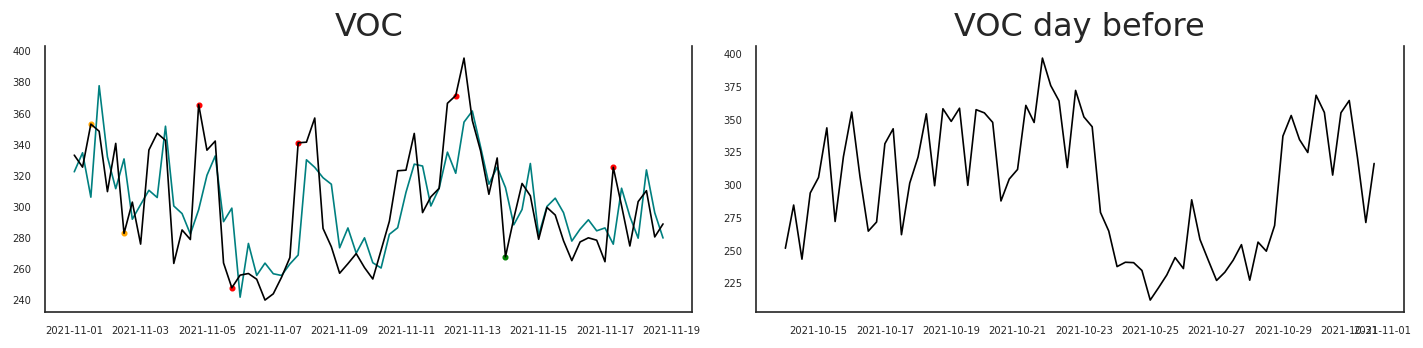

In [ ]:
anomalies_VOC_l= show_data_thresh[(data_thresh['Predictions_VOC'] == 1)]
anomalies_VOC_m= show_data_thresh[(data_thresh['Predictions_VOC'] == 2)]
anomalies_VOC_h= show_data_thresh[(data_thresh['Predictions_VOC'] == 3)]

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
%matplotlib inline

# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=120, figsize=(12,3))
for i, ax in enumerate(axes.flatten()):
    if(i%2==0):
      data_res=show_res['VOC']
      ax.plot(data_res, color='teal', linewidth=1)
      data_VOC = show_data_thresh['VOC']
      ax.plot(data_VOC, color='black', linewidth=1)
          
      # x axis value list.
      x_number_list_l = list(anomalies_VOC_l.index.values)
      # y axis value list.
      y_number_list_l = list(anomalies_VOC_l['VOC'].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_l, y_number_list_l, color='green', s=8)

      # x axis value list.
      x_number_list_m = list(anomalies_VOC_m.index.values)
      # y axis value list.
      y_number_list_m = list(anomalies_VOC_m['VOC'].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_m, y_number_list_m, color='orange', s=8)

      # x axis value list.
      x_number_list_h = list(anomalies_VOC_h.index.values)
      # y axis value list.
      y_number_list_h = list(anomalies_VOC_h['VOC'].values)
      # Draw point based on above x, y axis values.
      ax.scatter(x_number_list_h, y_number_list_h, color='red', s=8)


      # Decorations
      ax.set_title('VOC')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=6)
    else:
      data_before = day_before['VOC']
      ax.plot(data_before, color='black', linewidth=1)
      # Decorations
      ax.set_title('VOC day before')
      ax.xaxis.set_ticks_position('none')
      ax.yaxis.set_ticks_position('none')
      ax.spines["top"].set_alpha(0)
      ax.tick_params(labelsize=6)

plt.tight_layout();

# Showing the anomalies using distance from the var model expected values



The anomaly is shown with the 3 previous values, all the following anomalous values and the following 2 non-anomalous values

> The first anomaly is always the 4-th row



Diplay all the anomalies

In [ ]:
index_no = results_pred.columns.get_loc('Predictions')
i=0
while(i<len(results_pred)):
  if(results_pred.iloc[[i],[index_no]].values == 1):
    j=i+1
    if(j>=len(results_pred)):
      break
    else:
       while(results_pred.iloc[[j],[index_no]].values == 1):
          j=j+1
          if(j>=len(results_pred)):
            j=j-1
            break
    for s in range(i,j):
      print(s)
      d=0
      for col in df.columns:
        dis=float(usable.iloc[[s],[d]].values-res.iloc[[s],[d]].values)
        print(col+':'+str(dis))
        d=d+1
      print ('*' * 20)
    if(i-3<0):
      tmp=results_pred.iloc[i: j + 2]
      display(tmp)
    if(j+2>len(results_pred)):
      tmp=results_pred.iloc[i -3: j]
      display(tmp)
    else:
      tmp=results_pred.iloc[i - 3 : j + 2]
      display(tmp)
    i=j
  else:
    i=i+1    

0
O3:60.37387670306714
PM2.5:1.2782790063350153
CO2:-10.214053702719468
Temp. int.:3.518982093793916
T:2.6607049305489703
PM10:6.7720439659518
RH:-6.116943796992473
NO2:95.1873958268989
CO:9.651502483693747
VOC:17.207565925244353
********************


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC
Dates,,,,,,,,,,,,,,,,,,,,,
2021-08-02,328.395048,2.674919,408.648009,37.508095,24.416039,11.033369,583.980624,209.952637,221.217438,322.712594,1,268.021172,1.396640,418.862062,33.989113,21.755334,4.261325,590.097568,114.765241,211.565936,305.505028
2021-08-03,335.829947,1.801070,414.223529,36.878930,23.685989,6.512299,603.807487,205.767914,222.709091,324.391444,0,309.177317,0.889818,420.890446,35.816131,23.497112,6.542867,541.549523,117.617632,212.331180,316.968989
2021-08-04,363.098676,2.317690,413.270758,38.291865,24.596871,7.028881,616.511432,224.625752,227.711191,332.073406,0,271.772338,1.721763,419.022627,34.598630,22.346076,6.294755,552.172188,125.501200,209.138619,310.100059


,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC
Dates,,,,,,,,,,,,,,,,,,,,,


3
O3:138.2837368645894
PM2.5:1.731675339367315
CO2:-8.239700150664078
Temp. int.:5.017076794480857
T:3.2735267070150478
PM10:5.517619576065876
RH:125.20145824648534
NO2:143.09758588562022
CO:34.05979456078495
VOC:33.42759443560578
********************
4
O3:109.65582668013235
PM2.5:1.5274231337700517
CO2:-3.7133549235051646
Temp. int.:3.8507538257336975
T:2.4118217780874076
PM10:5.111080859714445
RH:122.33346108553337
NO2:142.18747155361794
CO:31.055300628039873
VOC:27.63376844829338
********************
5
O3:154.3305768852881
PM2.5:1.5408524136858668
CO2:8.173150390998785
Temp. int.:5.819243278009559
T:4.458369355788186
PM10:8.108305009071458
RH:34.18523755911576
NO2:194.55935549801046
CO:18.27689558465738
VOC:58.11267544273176
********************
6
O3:136.77049246481954
PM2.5:0.40458572223041256
CO2:8.067928044894302
Temp. int.:5.903910444228764
T:4.749410701147038
PM10:3.379271905485369
RH:-67.45717204479274
NO2:190.60746789446907
CO:9.38308105730917
VOC:57.651484026156595
*********

,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC
Dates,,,,,,,,,,,,,,,,,,,,,
2021-08-02,328.395048,2.674919,408.648009,37.508095,24.416039,11.033369,583.980624,209.952637,221.217438,322.712594,1,268.021172,1.396640,418.862062,33.989113,21.755334,4.261325,590.097568,114.765241,211.565936,305.505028
2021-08-03,335.829947,1.801070,414.223529,36.878930,23.685989,6.512299,603.807487,205.767914,222.709091,324.391444,0,309.177317,0.889818,420.890446,35.816131,23.497112,6.542867,541.549523,117.617632,212.331180,316.968989
2021-08-04,363.098676,2.317690,413.270758,38.291865,24.596871,7.028881,616.511432,224.625752,227.711191,332.073406,0,271.772338,1.721763,419.022627,34.598630,22.346076,6.294755,552.172188,125.501200,209.138619,310.100059
2021-08-05,357.354193,2.529412,406.629537,37.626408,24.007384,10.163955,695.724656,220.449312,238.334168,326.675845,1,219.070456,0.797736,414.869237,32.609331,20.733858,4.646335,570.523198,77.351726,204.274373,293.248250
2021-08-06,368.779956,2.891068,418.057734,38.071035,24.360784,11.481481,680.343137,254.114379,232.639434,334.448802,1,259.124130,1.363644,421.771089,34.220281,21.948963,6.370401,558.009676,111.926908,201.584133,306.815033
2021-08-07,417.820043,2.076509,422.089440,39.623427,26.203341,6.691810,630.110991,284.343750,231.670259,355.187500,1,263.489466,0.535656,413.916289,33.804183,21.744971,-1.416495,595.925754,89.784395,213.393363,297.074825
2021-08-08,401.059638,1.799787,425.652822,40.257604,26.788498,5.138445,529.003195,270.791267,223.179979,357.536741,1,264.289145,1.395201,417.584894,34.353693,22.039088,1.759173,596.460367,80.183799,213.796898,299.885257
2021-08-09,389.940412,1.444204,419.832069,39.128570,26.490141,5.063922,479.530878,242.198267,221.241603,355.403034,1,291.195592,2.213622,415.125949,33.386332,21.223022,7.348272,656.885585,120.377007,219.711135,308.878370
2021-08-10,465.185027,2.247059,419.014973,41.217048,28.990053,7.220321,507.050267,260.093048,235.383957,375.645989,1,361.417573,3.779673,427.661925,35.272764,22.439081,10.233303,740.212470,179.351666,231.999170,331.919046


Which anamaly do you want to display? (enter a number)

In [ ]:
input_a =int(input("Type the number of the anomaly you want to display:"))
index_no = results_pred.columns.get_loc('Predictions')
cnt=0
i=0
while(i<len(results_pred)):
  if(results_pred.iloc[[i],[index_no]].values == 1):
    cnt=cnt+1
    j=i+1
    if(j>=len(results_pred)):
      break
    else:
       while(results_pred.iloc[[j],[index_no]].values == 1):
          j=j+1
          if(j>=len(results_pred)):
            j=j-1
            break
    if(input_a == cnt):
      for s in range(i,j):
        d=0
        for col in df.columns:
          dis=float(usable.iloc[[s],[d]].values-res.iloc[[s],[d]].values)
          print(col+':'+str(dis))
          d=d+1
        print ('*' * 20)
      if(i-3<0):
        tmp=results_pred.iloc[i: j + 2]
        display(tmp)
      if(j+2>len(results_pred)):
        tmp=results_pred.iloc[i: j + 2]
        display(tmp)
      else:
        tmp=results_pred.iloc[i - 3 : j + 2]
        display(tmp)
      i=len(results_pred+1)
    i=j
  else:
    i=i+1  

Type the number of the anomaly you want to display:2
O3:138.2837368645894
PM2.5:1.731675339367315
CO2:-8.239700150664078
Temp. int.:5.017076794480857
T:3.2735267070150478
PM10:5.517619576065876
RH:125.20145824648534
NO2:143.09758588562022
CO:34.05979456078495
VOC:33.42759443560578
********************
O3:109.65582668013235
PM2.5:1.5274231337700517
CO2:-3.7133549235051646
Temp. int.:3.8507538257336975
T:2.4118217780874076
PM10:5.111080859714445
RH:122.33346108553337
NO2:142.18747155361794
CO:31.055300628039873
VOC:27.63376844829338
********************
O3:154.3305768852881
PM2.5:1.5408524136858668
CO2:8.173150390998785
Temp. int.:5.819243278009559
T:4.458369355788186
PM10:8.108305009071458
RH:34.18523755911576
NO2:194.55935549801046
CO:18.27689558465738
VOC:58.11267544273176
********************
O3:136.77049246481954
PM2.5:0.40458572223041256
CO2:8.067928044894302
Temp. int.:5.903910444228764
T:4.749410701147038
PM10:3.379271905485369
RH:-67.45717204479274
NO2:190.60746789446907
CO:9.38

,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC,Predictions,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC
Dates,,,,,,,,,,,,,,,,,,,,,
2021-08-05,357.354193,2.529412,406.629537,37.626408,24.007384,10.163955,695.724656,220.449312,238.334168,326.675845,1,219.070456,0.797736,414.869237,32.609331,20.733858,4.646335,570.523198,77.351726,204.274373,293.248250
2021-08-06,368.779956,2.891068,418.057734,38.071035,24.360784,11.481481,680.343137,254.114379,232.639434,334.448802,1,259.124130,1.363644,421.771089,34.220281,21.948963,6.370401,558.009676,111.926908,201.584133,306.815033
2021-08-07,417.820043,2.076509,422.089440,39.623427,26.203341,6.691810,630.110991,284.343750,231.670259,355.187500,1,263.489466,0.535656,413.916289,33.804183,21.744971,-1.416495,595.925754,89.784395,213.393363,297.074825
2021-08-08,401.059638,1.799787,425.652822,40.257604,26.788498,5.138445,529.003195,270.791267,223.179979,357.536741,1,264.289145,1.395201,417.584894,34.353693,22.039088,1.759173,596.460367,80.183799,213.796898,299.885257
2021-08-09,389.940412,1.444204,419.832069,39.128570,26.490141,5.063922,479.530878,242.198267,221.241603,355.403034,1,291.195592,2.213622,415.125949,33.386332,21.223022,7.348272,656.885585,120.377007,219.711135,308.878370
2021-08-10,465.185027,2.247059,419.014973,41.217048,28.990053,7.220321,507.050267,260.093048,235.383957,375.645989,1,361.417573,3.779673,427.661925,35.272764,22.439081,10.233303,740.212470,179.351666,231.999170,331.919046
2021-08-11,500.620280,2.744337,418.703344,42.810475,30.770227,8.325782,528.960086,244.282632,245.196332,380.053937,1,267.965991,2.058808,419.637214,33.590278,21.161466,-0.709766,682.214979,103.155413,218.095782,301.255131
2021-08-12,467.994530,2.923414,425.927790,42.696641,30.833151,7.039387,435.471554,226.956236,231.795405,384.992341,1,263.513789,1.855950,418.259564,32.998234,20.701124,0.297226,658.738626,118.260480,214.961749,303.820345
2021-08-13,504.587097,3.458065,424.004301,43.364108,31.374624,7.566667,439.583871,248.539785,243.827957,384.563441,1,333.181923,2.622107,418.832715,33.646037,21.280938,7.318529,711.515940,153.280175,229.463852,314.132771


# Forecasting using the VAR model

Splitting the series into train and testing data (nobs= how many values are test values)

In [ ]:
nobs = 72
df_train, df_test = df_copy[0:-nobs].copy(), df_copy[-nobs:].copy()

# Check size
print(df_train.shape)  
print(df_test.shape)  

(493, 10)
(72, 10)


In [ ]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(ts_data, column='', signif=0.05, series=False):
    if series:
        adf_test = adfuller(ts_data, autolag='AIC')
    else:
        adf_test = adfuller(ts_data[column], autolag='AIC')
    p_value = adf_test[1]                   
    if p_value <= signif:
        test_result = "Stationary"
    else:
        test_result = "Non-Stationary"
    return test_result

adf_test_results = {
    col: test_stationarity(df_train, col)
    for col in df_train.columns
}
adf_test_results  

{'CO': 'Stationary',
 'CO2': 'Stationary',
 'NO2': 'Non-Stationary',
 'O3': 'Stationary',
 'PM10': 'Stationary',
 'PM2.5': 'Non-Stationary',
 'RH': 'Stationary',
 'T': 'Non-Stationary',
 'Temp. int.': 'Non-Stationary',
 'VOC': 'Stationary'}

Use the differencing only on the variables that need it 

In [ ]:
def differencing(data, column, order):
    differenced_data = data[column].diff(order)
    differenced_data.fillna(differenced_data.mean(), inplace=True)
    return differenced_data
for col in ['T', 'Temp. int.', 'NO2', 'PM2.5']:
    df_train[col] = differencing(df_train, col, 1)

In [ ]:
from statsmodels.tsa.api import VAR

max_lag=20
model = VAR(df_train)
lag_results_for = model.select_order(max_lag)
selected_lag_for = lag_results_for.aic
print(selected_lag_for)
model_fitted = model.fit(selected_lag_for)



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5


In [ ]:
# Input data for forecasting
forecast_input = df_train.iloc[-selected_lag_for:].values


Forecast number is the number of observetion you want to forecast. You should choose 6 if you want to forecast the next hour

In [ ]:
# Forecast
forecast_number=6
fc = model_fitted.forecast(y=forecast_input, steps=forecast_number)
df_forecast = pd.DataFrame(fc, index=df_copy.index[-nobs:-(nobs-forecast_number)], columns=df_copy.columns)
df_forecast

,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC
Dates,,,,,,,,,,
2021-11-01 00:00:00,372.452094,2.251777,461.503609,-3.630506,-3.640879,22.128426,878.842254,79.621673,216.049221,327.050315
2021-11-01 06:00:00,346.519330,-2.450519,458.695859,2.690203,2.668376,25.967996,778.171443,-29.681096,208.525423,314.019141
2021-11-01 12:00:00,175.655851,-5.987043,421.716077,2.579188,3.094159,15.348173,617.392052,-117.870597,208.851185,270.064366
2021-11-01 18:00:00,239.508636,1.138475,430.110484,-1.498870,-1.759424,10.505040,681.588413,36.950296,211.277599,300.020530
2021-11-02 00:00:00,302.789299,4.072393,453.908023,-3.339024,-3.335696,19.604835,819.779878,74.731480,209.991452,310.051341
2021-11-02 06:00:00,288.249998,-1.080678,452.330571,1.766443,1.665422,19.015051,760.874388,-19.705179,207.644180,302.849251


Revert the differencing

In [ ]:
df_results=pd.DataFrame(index=df_copy.index[-nobs-1:-(nobs-forecast_number)], columns=df_copy.columns)
for col in ['T', 'Temp. int.', 'NO2', 'PM2.5']:
  x, x_diff = df_copy[col].iloc[-(nobs+1):-nobs], df_forecast[col]
  df_results[col] = np.r_[x, x_diff].cumsum()
df_results=df_results.iloc[-forecast_number:]


Add the ones that were not differenced

In [ ]:
for col in df_d.columns.difference(['T', 'Temp. int.', 'NO2', 'PM2.5']):
  df_results[col]=df_forecast[col]

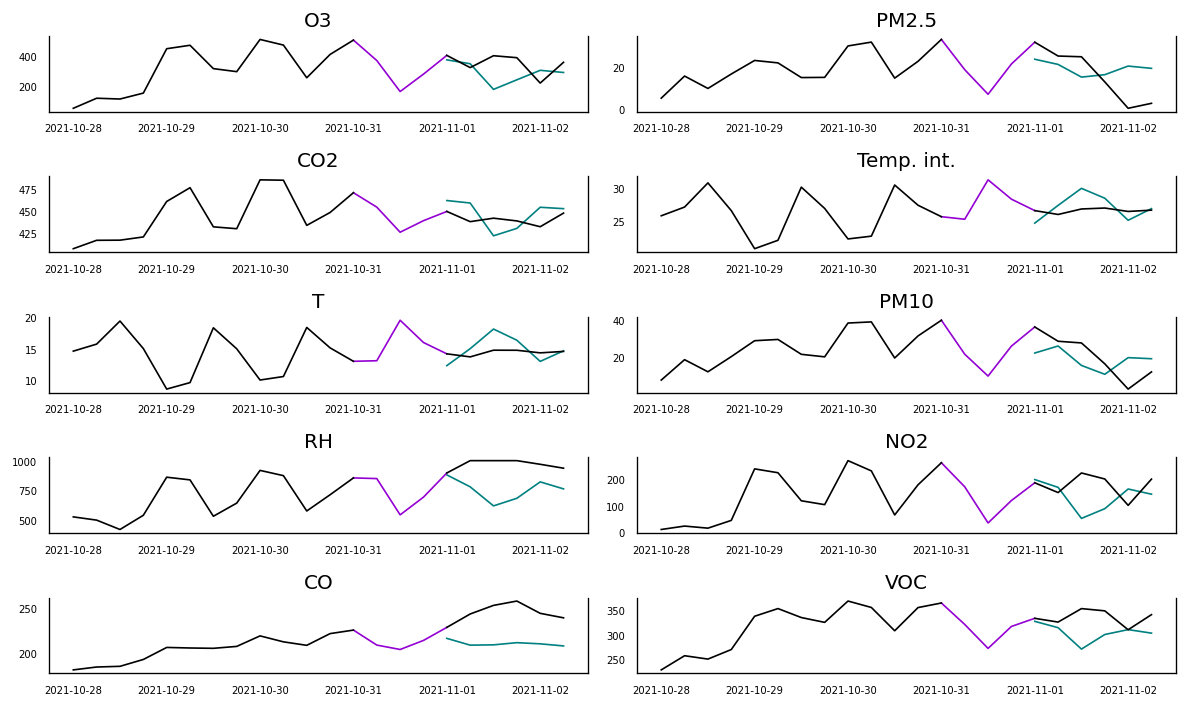

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

show_lag=df_copy.iloc[-(nobs+selected_lag_for)+1:-nobs+1]
before_lag=df_copy.iloc[-(8*2+nobs):-(nobs+selected_lag_for)+2]
show_test=df_copy.iloc[-nobs:-(nobs-forecast_number)]
# Plot
fig, axes = plt.subplots(nrows=5, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data_lag=show_lag[df_copy.columns[i]]
    data_before=before_lag[df_copy.columns[i]]
    data_test=show_test[df_copy.columns[i]]
    data_fc=df_results[df_results.columns[i]]
    ax.plot(data_fc, color='teal', linewidth=1)
    ax.plot(data_lag,color='darkviolet', linewidth=1)
    ax.plot(data_before, color='black', linewidth=1)
    ax.plot(data_test, color='black', linewidth=1)
    # Decorations
    ax.set_title(df_copy.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

Forecast number is the number of observetion you want to forecast. You should choose 6 if you want to forecast the next hour

In [ ]:
# Forecast
forecast_number=12
fc = model_fitted.forecast(y=forecast_input, steps=forecast_number)
df_forecast = pd.DataFrame(fc, index=df_copy.index[-nobs:-(nobs-forecast_number)], columns=df_copy.columns )
df_forecast

,O3,PM2.5,CO2,Temp. int.,T,PM10,RH,NO2,CO,VOC
Dates,,,,,,,,,,
2021-11-01 00:00:00,372.452094,2.251777,461.503609,-3.630506,-3.640879,22.128426,878.842254,79.621673,216.049221,327.050315
2021-11-01 06:00:00,346.519330,-2.450519,458.695859,2.690203,2.668376,25.967996,778.171443,-29.681096,208.525423,314.019141
2021-11-01 12:00:00,175.655851,-5.987043,421.716077,2.579188,3.094159,15.348173,617.392052,-117.870597,208.851185,270.064366
2021-11-01 18:00:00,239.508636,1.138475,430.110484,-1.498870,-1.759424,10.505040,681.588413,36.950296,211.277599,300.020530
2021-11-02 00:00:00,302.789299,4.072393,453.908023,-3.339024,-3.335696,19.604835,819.779878,74.731480,209.991452,310.051341
2021-11-02 06:00:00,288.249998,-1.080678,452.330571,1.766443,1.665422,19.015051,760.874388,-19.705179,207.644180,302.849251
2021-11-02 12:00:00,180.701261,-4.658993,425.521131,2.579132,2.868626,10.981652,624.219913,-82.158073,206.709396,274.142174
2021-11-02 18:00:00,239.420872,2.487071,430.323390,-0.636195,-0.774872,12.659174,656.849011,29.747616,207.564529,300.457940
2021-11-03 00:00:00,269.618340,2.791529,446.756206,-3.410486,-3.372254,17.600472,786.490122,45.223678,208.499110,302.879683


Revert the differencing

In [ ]:
df_results=pd.DataFrame(index=df_copy.index[-nobs-1:-(nobs-forecast_number)], columns=df_copy.columns)
for col in ['T', 'Temp. int.', 'NO2', 'PM2.5']:
  x, x_diff = df_copy[col].iloc[-(nobs+1):-nobs], df_forecast[col]
  df_results[col] = np.r_[x, x_diff].cumsum()
df_results=df_results.iloc[-forecast_number:]

Add the ones that were not differenced

In [ ]:
for col in df_d.columns.difference(['T', 'Temp. int.', 'NO2', 'PM2.5']):
  df_results[col]=df_forecast[col]

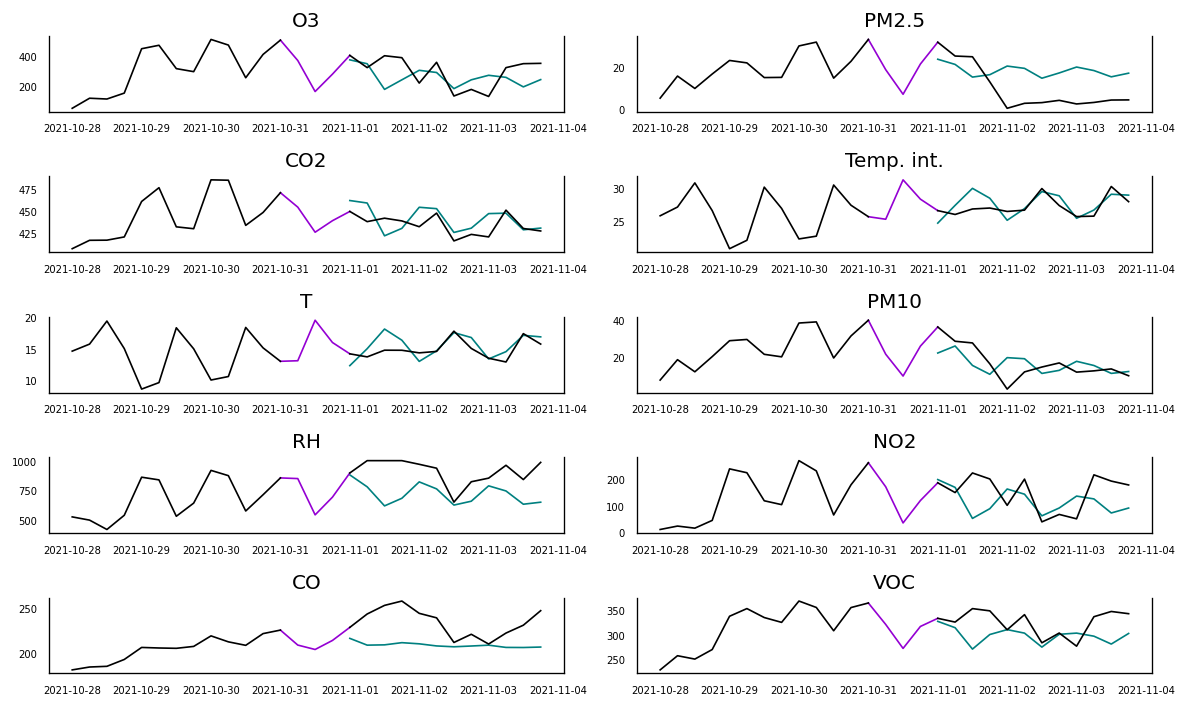

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

show_lag=df_copy.iloc[-(nobs+selected_lag_for)+1:-nobs+1]
before_lag=df_copy.iloc[-(8*2+nobs):-(nobs+selected_lag_for)+2]
show_test=df_copy.iloc[-nobs:-(nobs-forecast_number)]
# Plot
fig, axes = plt.subplots(nrows=5, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data_lag=show_lag[df_copy.columns[i]]
    data_before=before_lag[df_copy.columns[i]]
    data_test=show_test[df_copy.columns[i]]
    data_fc=df_results[df_results.columns[i]]
    ax.plot(data_fc, color='teal', linewidth=1)
    ax.plot(data_lag,color='darkviolet', linewidth=1)
    ax.plot(data_before, color='black', linewidth=1)
    ax.plot(data_test, color='black', linewidth=1)
    # Decorations
    ax.set_title(df_copy.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();